In [42]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [43]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.sin(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, P_0, phi, C = parameters
    return P_0*np.sin(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k *10**5) #de 10**5 is om de vage eenheden die nodig zijn om de fits te doen werken te fixen

In [44]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0

In [45]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, print_tijdfit = True, detailed_logs = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        def invals_amplitude(x,y):
            if invals is None:
                return [1,0,0,0]
            else:
                return invals[xval]
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        if print_tijdfit:
            print('x-coordinaat:',X[xval])
            #plot het boeltje om te testen
            fig, ax = plt.subplots(1,1, figsize = (30,10))
            ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
            T_fit = np.linspace(0, max(tijd),30000)
            druk_fit = tijdfit[1][0]*np.sin(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
            ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)
            testing = np.full(np.shape(T_fit), np.max(druk)) #Mijn vader beweerde iets raar te zien in de data, dus ff checken
            testing_min = np.full(np.shape(T_fit), np.min(druk)) #tis fine denk ik
            ax.plot(T_fit, testing)
            ax.plot(T_fit, testing_min)

            ax.set_ylabel('$V_0$ [mV]')
            ax.set_xlabel('T (s)')
            ax.legend("druk in functie van tijd")
            ax.legend()
            plt.tight_layout()
            plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, invals = None, range_x = None, detailed_logs = False, fuck_mijn_pc = True, fuck_CPU = False):
    def invals_naarx(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_naarx, X, P_0_x, P_0_x_ERR, initial_range=range_x, detailed_logs= detailed_logs, fuck_mijn_pc=fuck_mijn_pc, fuck_CPU = fuck_CPU)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, gok_snelheid = 380,range_x = None,fuck_mijn_pc=False, detailed_logs = False, 
             print_tijdfit = True, fit_x_vals = True, fuck_CPU = False, saveto = None):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, print_tijdfit = print_tijdfit, detailed_logs = detailed_logs and print_tijdfit)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    print(P_0_x_ERR, 'P_0(x): de error')
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    """
    #eerst als eens de punten plotten zodat we weten wat ermee aan te vangen indien het crasht
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')
    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()
    """
    #en nu voor echt fitten
    #beginwaardes bepalen
    minimum = min(P_0_x)
    maximum = max(P_0_x)
    if not invals_vaste_x is None:
        omega_gok = invals_vaste_x[0][0]
    else:
        omega_gok = OMEGA.get_val()
    Kgok = omega_gok*10**5/gok_snelheid
    phigok = np.arcsin(P_0_x[0]/(maximum - minimum)) - Kgok*X[0]
    invals = [Kgok+5, maximum-minimum+20, phigok, minimum]
    if fit_x_vals:
        print('initial values', invals)
        K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR),invals, range_x = range_x, detailed_logs = detailed_logs,fuck_mijn_pc=fuck_mijn_pc, fuck_CPU=fuck_CPU)

        x_fit = np.linspace(0,max(X),5000)
        druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
        druk_initial = invals[1]*abs(np.sin(invals[0]*x_fit+invals[2]) + invals[3])
        #plot het boeltje
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(X, P_0_x, yerr = abs(P_0_x_ERR), label = 'gemeten', linestyle = ' ', marker = 'o')
        if saveto is None:
            ax.plot(x_fit, druk_initial, label = 'initiele waarden')
        ax.plot(x_fit, druk_fit, label = 'model')

        ax.set_ylabel('$V_0$ [mV]',fontsize = 18)
        ax.set_xlabel('x (m)', fontsize = 18)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        ax.set_title("drukamplitude in functie van positie", fontsize = 25)
        ax.legend(fontsize = 15)
        plt.tight_layout()
        if not saveto is None:
            plt.savefig(saveto+'figure.png')
        plt.show()

        #bereken de snelheid
        snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
        print(snelheid)
        return [K, P_0, PHI, c, OMEGA]
    else:
        return [P_0_x, P_0_x_ERR, invals]


In [46]:
#### Hier volgt de effectieve data-analyse
#fix_data(X, T, P, P_fout, detailed_logs=False)

In [47]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files

    #@return: T in 10^-5 s (bro da werkt beter smh)

    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-1)# *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**2
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    if Vpart[0] < Vpart[1]:
        phi = np.arcsin((Vpart[0] - C)/amplitude)
    else:
        phi = np.pi - np.arcsin((Vpart[0] - C)/amplitude)

    

    
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [48]:
def uncook_data(Tpart, Vpart, V_part_fout):
    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

def get_data_from_folder(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = []
    Vfout = []
    #for i in range(5):
    COOKED = 0
    for filenaam in onlyfiles[1:]:# -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
        #                            ------- De eerste meting is een uitschieter dus skip die
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[9:-4])*10**(-3)
        afstanden.append(nummer)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    return [V, T, Vfout, afstanden, invals]

In [49]:
"""fig, ax = plt.subplots(1,1, figsize=(30,10))
ax.errorbar(afstanden, np.transpose(invals)[1], fmt='o')
plt.show()"""

"fig, ax = plt.subplots(1,1, figsize=(30,10))\nax.errorbar(afstanden, np.transpose(invals)[1], fmt='o')\nplt.show()"

FUCK YOU DE DATA IS COOKED
1
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1314769.2944890196
             x: [ 6.663e-02  2.409e+01  3.149e+00  6.285e+00]
           nit: 222
          nfev: 369
 final_simplex: (array([[ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       ...,
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00]]), array([ 1.315e+06,  1.315e+06,  1.315e+06,  1.315e+06,
                        1.315e+06]))
[[0.06663281232749563, 0.10840535996484753], [24.083276456521737, 24.091952289503634], [3.1483387596397807, 3.1486982536116312], [6.282321576148621, 6.288450487477068]]
omega heeft als waarde: 0.066633 + 0.041772 - 1.5587e-07 met 68% betrouwbaarheidsinterval: [0.066633, 0.10841] 
p_0_x heeft als waarde: 24.088 + 0

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[[0.011808164311180114, 0.06663854263841534], [146.2979451034173, 146.3066444293621], [2.4798340965973535, 2.4798931262550754], [0.16231302600922415, 0.16844194912067142]]
omega heeft als waarde: 0.066639 + 2.5495e-08 - 0.05483 met 68% betrouwbaarheidsinterval: [0.011808, 0.066639] 
p_0_x heeft als waarde: 146.3 + 0.0043546 - 0.0043447 met 68% betrouwbaarheidsinterval: [146.3, 146.31] 
phi heeft als waarde: 2.4799 + 2.9468e-05 - 2.9561e-05 met 68% betrouwbaarheidsinterval: [2.4798, 2.4799] 
C heeft als waarde: 0.16537 + 0.0030734 - 0.0030555 met 68% betrouwbaarheidsinterval: [0.16231, 0.16844] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 2768.5



[[0.06663851714328738, (0.055, 2.5e-08), 'S'], [146.30228984884155, 0.0044, 'S'], [2.479863658010955, 3e-05, 'S'], [0.16536854150408964, 0.0031, 'S']] tijdfit
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
          

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13608675.92214889
             x: [ 6.666e-02  1.435e+02  2.411e+00  3.420e+00]
           nit: 148
          nfev: 268
 final_simplex: (array([[ 6.666e-02,  1.435e+02,  2.411e+00,  3.420e+00],
                       [ 6.666e-02,  1.435e+02,  2.411e+00,  3.420e+00],
                       ...,
                       [ 6.666e-02,  1.435e+02,  2.411e+00,  3.420e+00],
                       [ 6.666e-02,  1.435e+02,  2.411e+00,  3.420e+00]]), array([ 1.361e+07,  1.361e+07,  1.361e+07,  1.361e+07,
                        1.361e+07]))
[[0.0005349517373599271, 0.06666001063266415], [143.5319941266726, 143.5406935459441], [2.4109563919837655, 2.4110165585969248], [3.4166801607751482, 3.4228090610456237]]
omega heeft als waarde: 0.06666 + 2.6048e-08 - 0.066125 met 68% betrouwbaarheidsinterval: [0.00053495, 0.06666] 
p_0_x heeft als waarde: 143.54 + 0.0043518 - 0.0043476 met 68% betrouwba

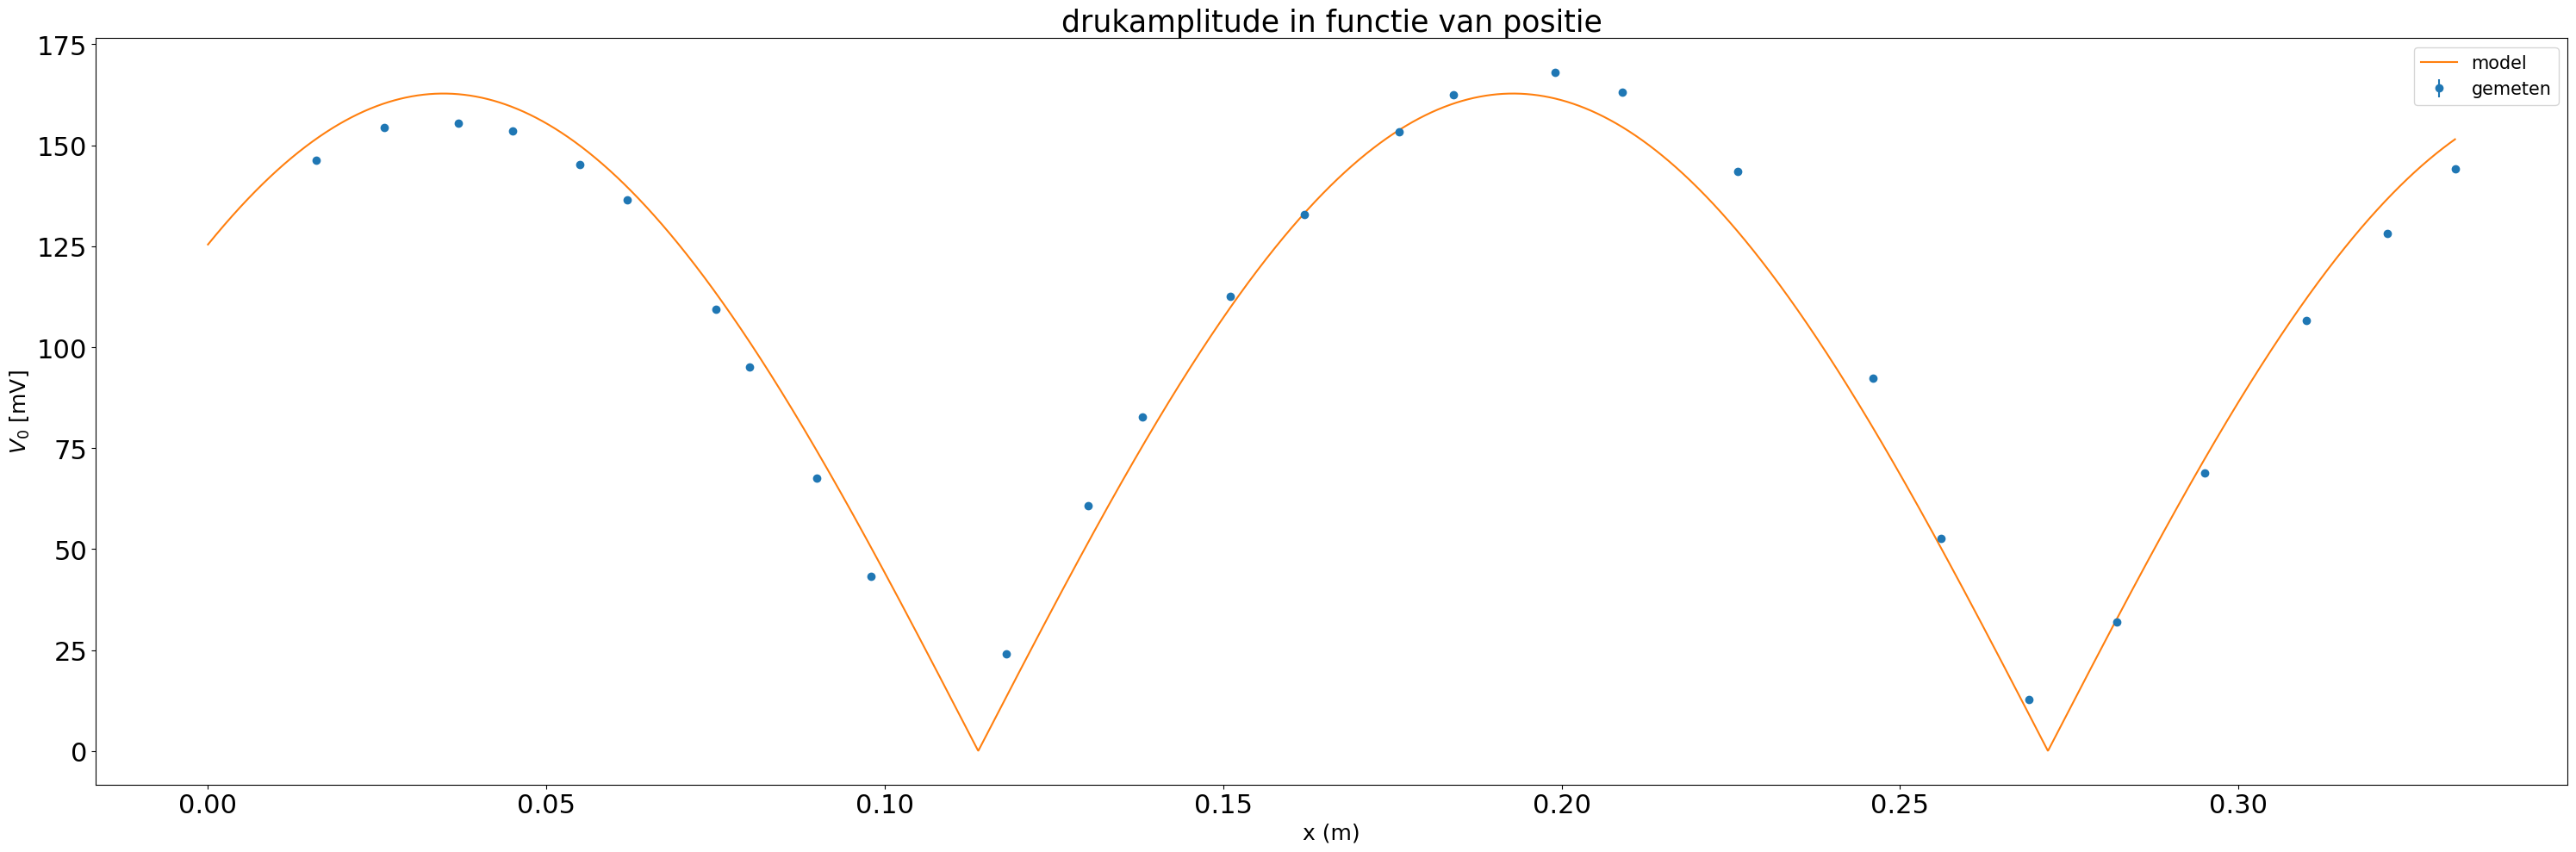

datapunt: v = [335.337232982384, 0.00253294229743644, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
2
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 856450.8848973574
             x: [ 6.629e-02  2.504e+01  3.939e+00 -4.535e+00]
           nit: 170
          nfev: 299
 final_simplex: (array([[ 6.629e-02,  2.504e+01,  3.939e+00, -4.535e+00],
                       [ 6.629e-02,  2.504e+01,  3.939e+00, -4.535e+00],
                       ...,
                       [ 6.629e-02,  2.504e+01,  3.939e+00, -4.535e+00],
                       [ 6.629e-02,  2.504e+01,  3.939e+00, -4.535e+00]]), array([ 8.565e+05,  8.565e+05,  8.565e+05,  8.565e+05,
                        8.565e+05]))
[[0.13632589336135312, 0.08915352131272533], [25.033956362543236, 25.042612689974618], [3.938592407109311, 3.938939034861845], [-4.531607896099208, -4.537736822050273]]
omega heeft als waarde: 0.06

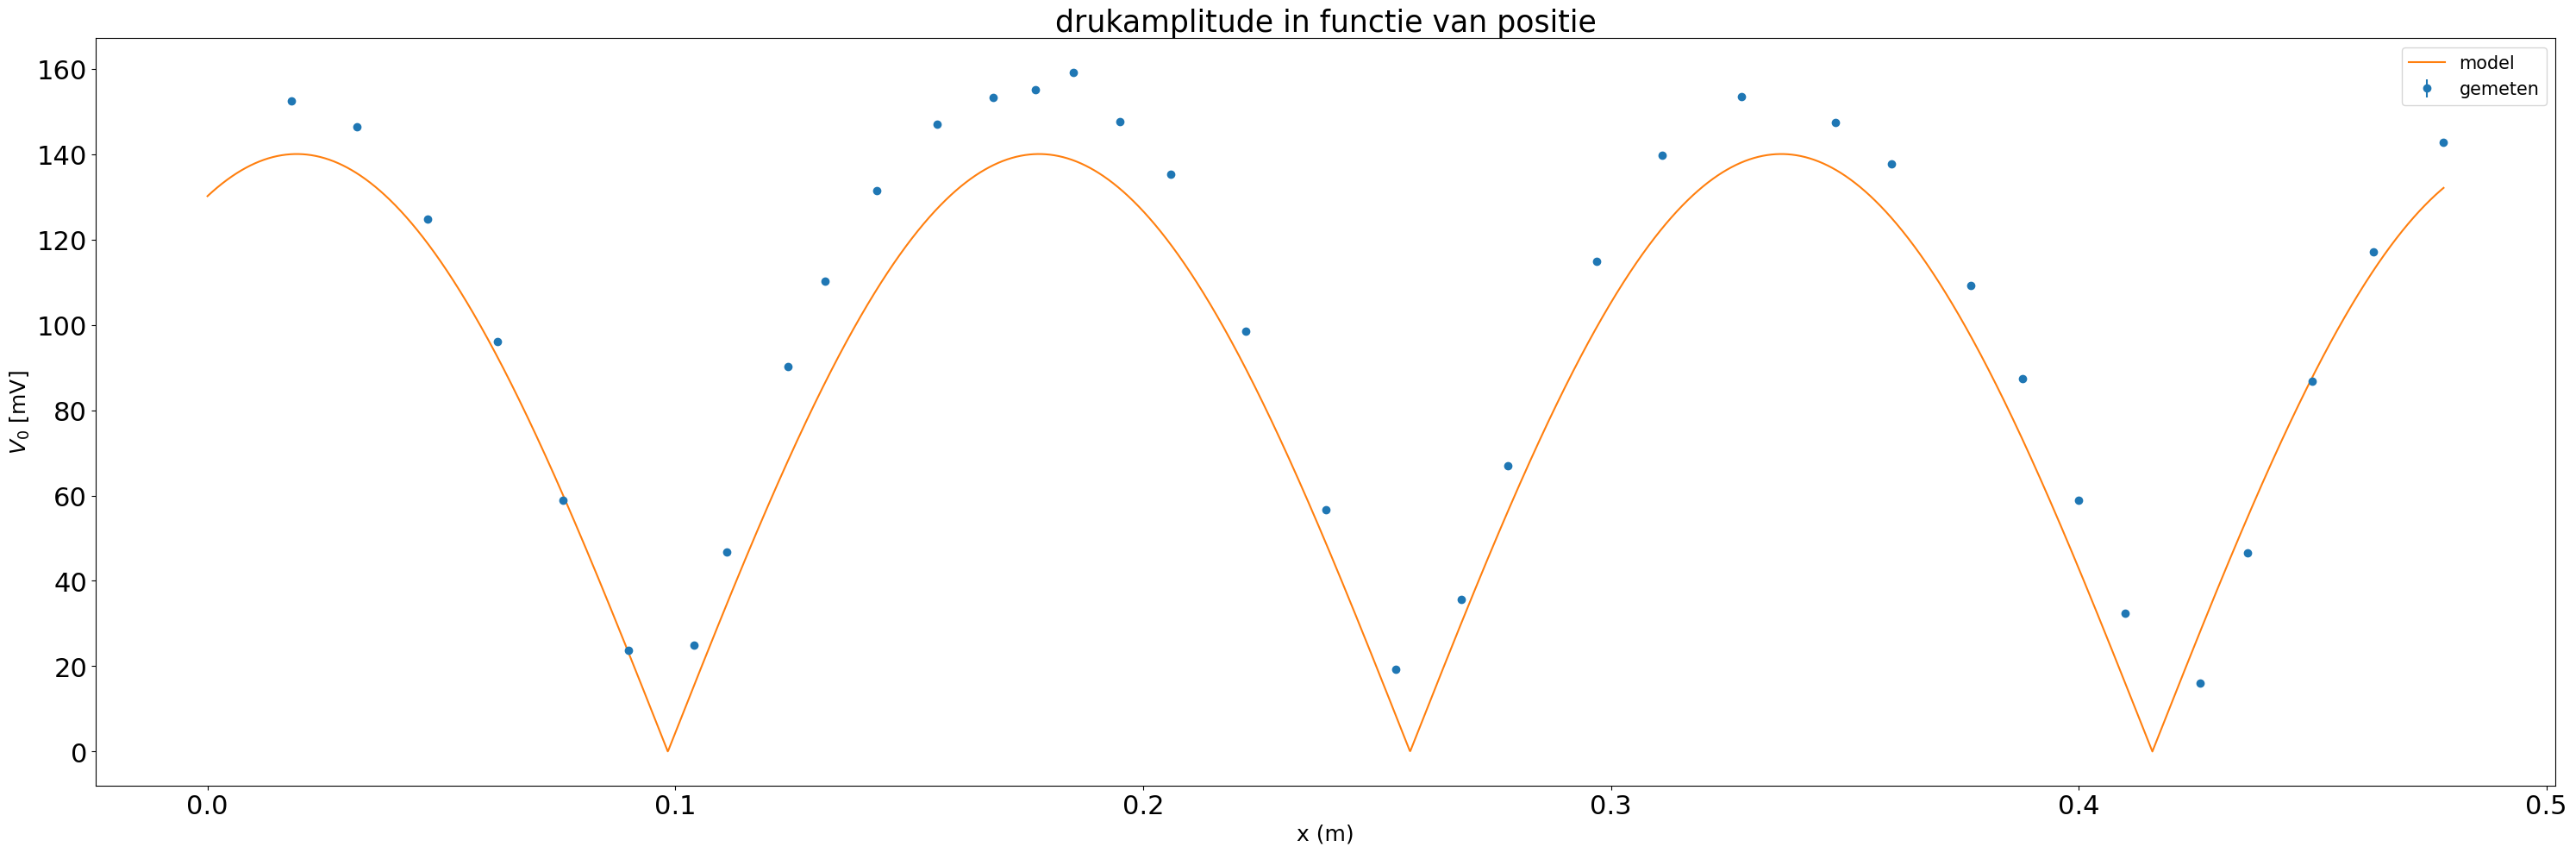

datapunt: v = [335.729940285356, 2.54340992322634, 'Normaal']
0
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 694007.7438490754
             x: [ 6.669e-02  1.893e+01  3.434e+00  6.826e+00]
           nit: 177
          nfev: 314
 final_simplex: (array([[ 6.669e-02,  1.893e+01,  3.434e+00,  6.826e+00],
                       [ 6.669e-02,  1.893e+01,  3.434e+00,  6.826e+00],
                       ...,
                       [ 6.669e-02,  1.893e+01,  3.434e+00,  6.826e+00],
                       [ 6.669e-02,  1.893e+01,  3.434e+00,  6.826e+00]]), array([ 6.940e+05,  6.940e+05,  6.940e+05,  6.940e+05,
                        6.940e+05]))
[[0.1491937609231895, 0.14917286521163042], [18.926107285351904, 18.934761969116227], [3.433286950466286, 3.4337455076492196], [6.8227155311998295, 6.828844441721544]]
omega heeft als waarde: 0.066689 + 0.082483 - -0.082504 met 68% betrouwbaarheidsinterval: [0.14919, 0.14917] 
p_0

c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\functies.py:252: OptimizeWarning: Initial guess is not within the specified bounds
  mini = minimize(chi2_func, gok, bounds = bounds, args = (x_val, y_val, y_err, soort_fout, model), method="Nelder-Mead")


[[19.650242940000005, 19.800149012000006], [149.585607716, 180.000149012], [-1.9419054402110545, -1.9416074162110544], [0.021256459763932686, 0.021554483763932687]]
k heeft als waarde: 19.8 + 0.00014901 - 0.14976 met 68% betrouwbaarheidsinterval: [19.65, 19.8] 
p_0 heeft als waarde: 180 + 0.00014901 - 30.414 met 68% betrouwbaarheidsinterval: [149.59, 180] 
phi heeft als waarde: -1.9418 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [-1.9419, -1.9416] 
C heeft als waarde: 0.021405 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [0.021256, 0.021554] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 9.6734e+06


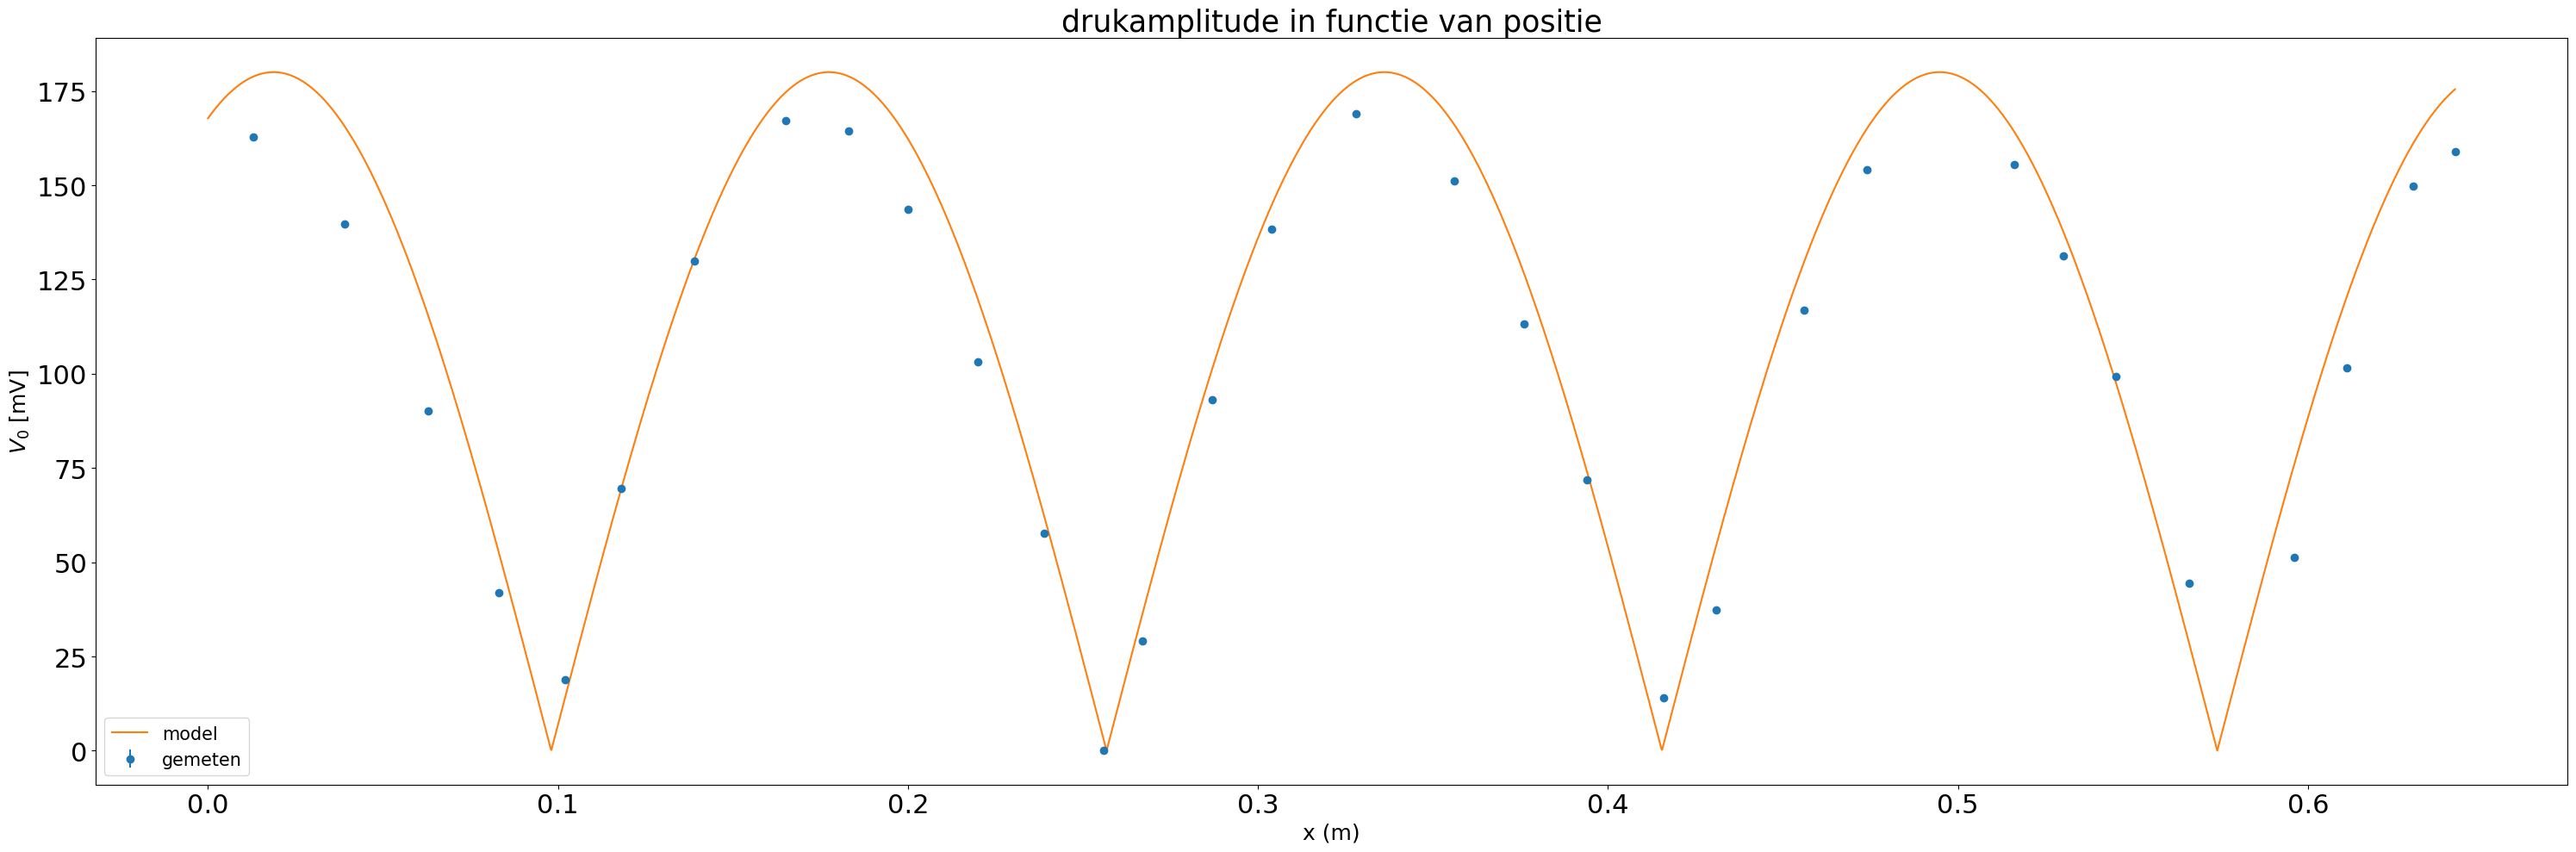

datapunt: v = [336.528422082778, 13.9478004037968, 'Normaal']
________met de 3 experimenten samen:_______
datapunt: v = [335.192941768571, 0.00253147130113244, 'Normaal']


In [50]:
#de experimenten op 1000Hz
#het werkt, gewoon ff gecomment om met de run all verder te kunnen werken

lengtes = ['35.3', '50.0', '66.4']
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 380, 430]
gokranges = [None, [(19.8, 6600/380+5.01), (140, 180), (-0.1-2*np.pi,2*np.pi), (0,20)], [(19.8, 6600/380+5.01), (140, 180), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [True, False, False]
Kwaardes = []
omegawaardes = []
for indx in range(len(lengtes)):
    lengte = lengtes[indx]
    mypath = "metingen laweit/1000Hz, "+lengte+"cm"
    V, T, V_fout, afstanden, invals = get_data_from_folder(mypath)
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
                                             detailed_logs=False, print_tijdfit = False, fit_x_vals=True, fuck_CPU = True, saveto = mypath)
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')
print(snelheid)

In [51]:
def get_data_from_folder_and_step(mypath, step):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = []
    Vfout = []
    #for i in range(5):
    COOKED = 0
    minimum = None
    for filenaam in onlyfiles[1:]:# -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
        #                            ------- De eerste meting is een uitschieter dus skip die
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[8:11])*10**(-3)
        if minimum is None:
            minimum = nummer
        afstanden.append((nummer-minimum)*step)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    print('tijd:',T)
    return [V, T, Vfout, afstanden, invals]

FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
5
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3261670.1455489113
             x: [ 1.249e-01  8.174e+01  6.751e-01  1.328e+01]
           nit: 240
          nfev: 409
 final_simplex: (array([[ 1.249e-01, 

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[[0.30738322609816177, 0.39541152273372887], [67.94935963743451, 67.95802045465047], [1.3411686521558055, 1.3412963029475953], [12.229718983108974, 12.235847880399172]]
omega heeft als waarde: 0.12429 + 0.27112 - -0.18309 met 68% betrouwbaarheidsinterval: [0.30738, 0.39541] 
p_0_x heeft als waarde: 67.954 + 0.0043259 - 0.004335 met 68% betrouwbaarheidsinterval: [67.949, 67.958] 
phi heeft als waarde: 1.3412 + 6.3849e-05 - 6.3802e-05 met 68% betrouwbaarheidsinterval: [1.3412, 1.3413] 
C heeft als waarde: 12.233 + 0.0030654 - 0.0030635 met 68% betrouwbaarheidsinterval: [12.23, 12.236] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 366.07



[[0.12429330560676217, (-0.18, 0.27), 'S'], [67.95369459447565, 0.0043, 'S'], [1.3412324539998424, 6.4e-05, 'S'], [12.232782506314432, 0.0031, 'S']] tijdfit
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 898947.

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[[-2.3244900600433933, 0.27287829384888485], [46.76799527379265, 46.776651983024614], [1.3353737677706856, 1.3355593149884013], [10.842998558527183, 10.849127494068396]]
omega heeft als waarde: 0.12444 + 0.14844 - 2.4489 met 68% betrouwbaarheidsinterval: [-2.3245, 0.27288] 
p_0_x heeft als waarde: 46.772 + 0.0043249 - 0.0043318 met 68% betrouwbaarheidsinterval: [46.768, 46.777] 
phi heeft als waarde: 1.3355 + 9.2726e-05 - 9.2821e-05 met 68% betrouwbaarheidsinterval: [1.3354, 1.3356] 
C heeft als waarde: 10.846 + 0.0030753 - 0.0030536 met 68% betrouwbaarheidsinterval: [10.843, 10.849] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 417.42



[[0.12443588942124204, (2.4, 0.15), 'S'], [46.77232707834598, 0.0043, 'S'], [1.3354665891962982, 9.3e-05, 'S'], [10.846052163397275, 0.0031, 'S']] tijdfit
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2143825.

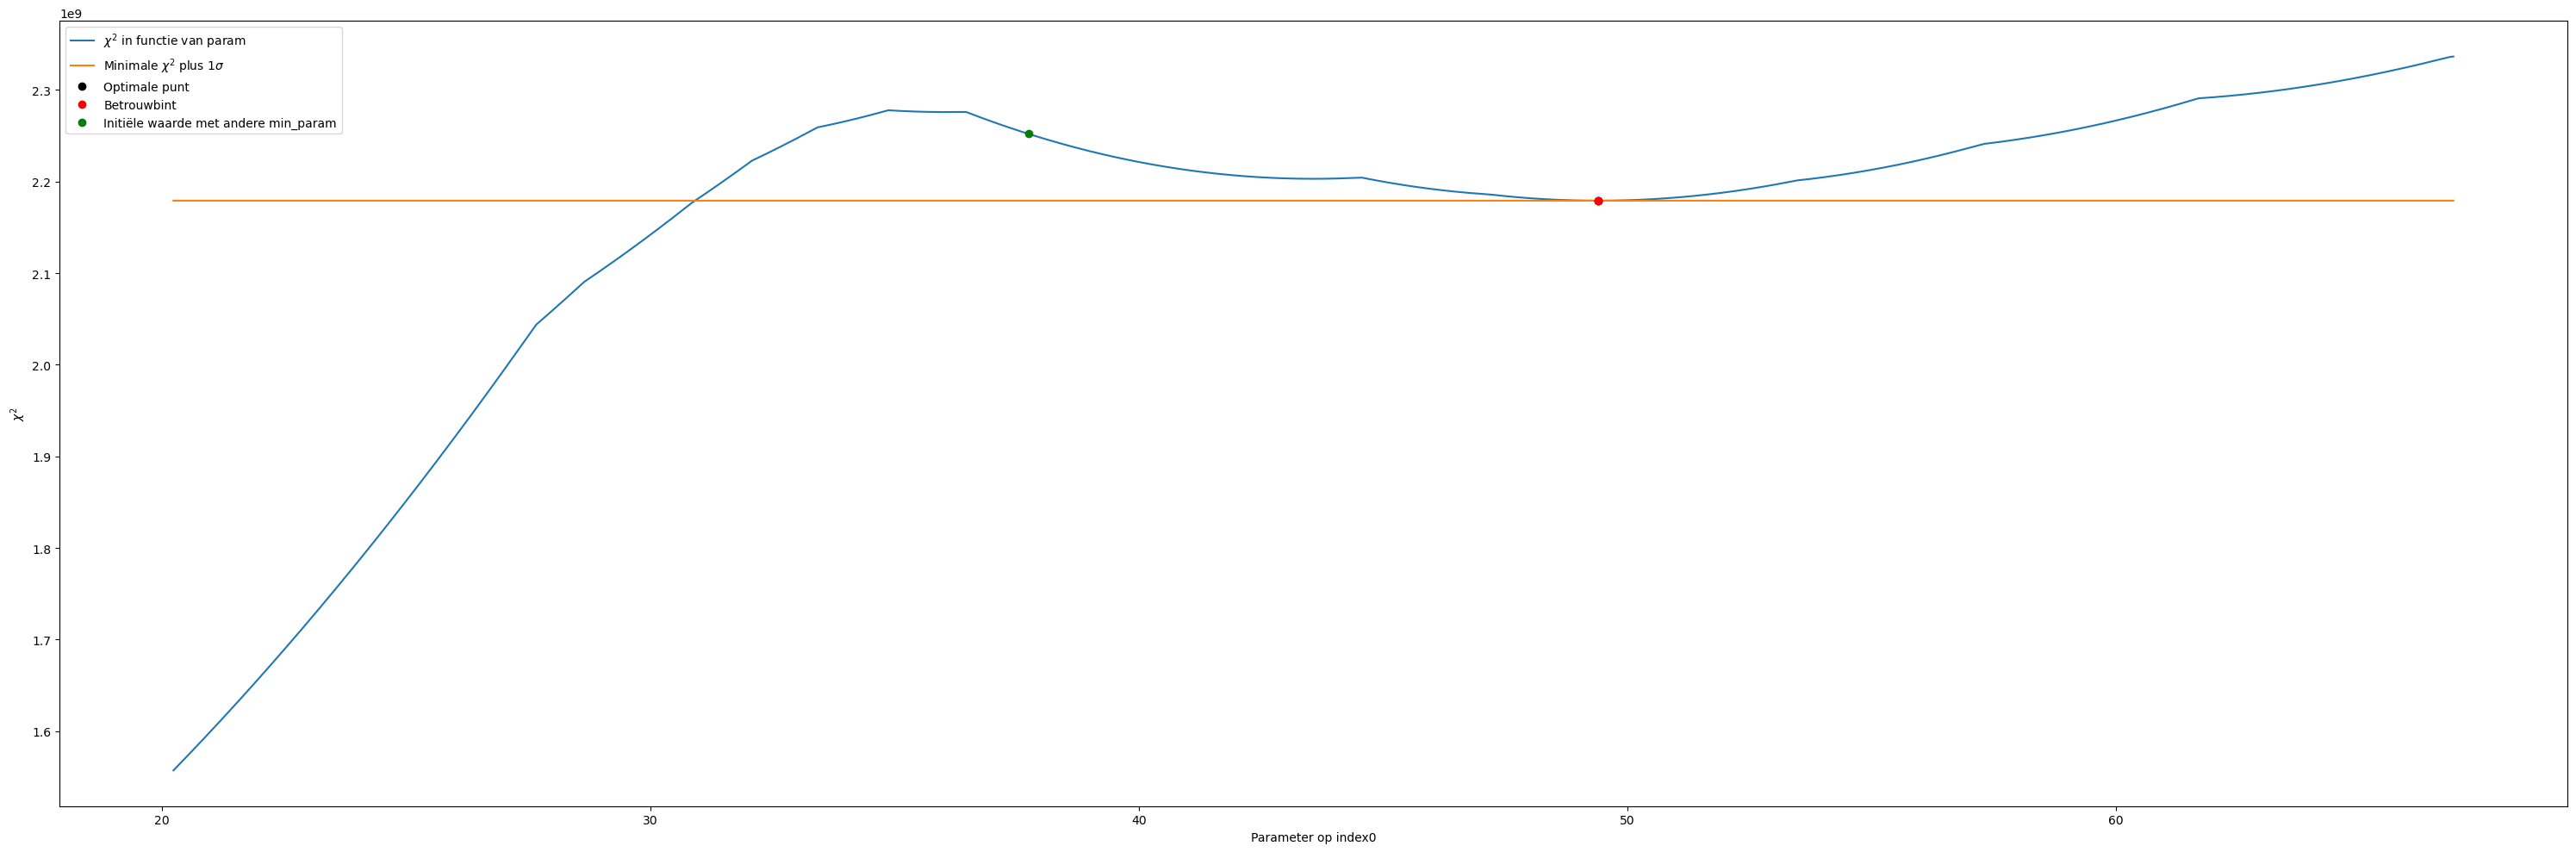

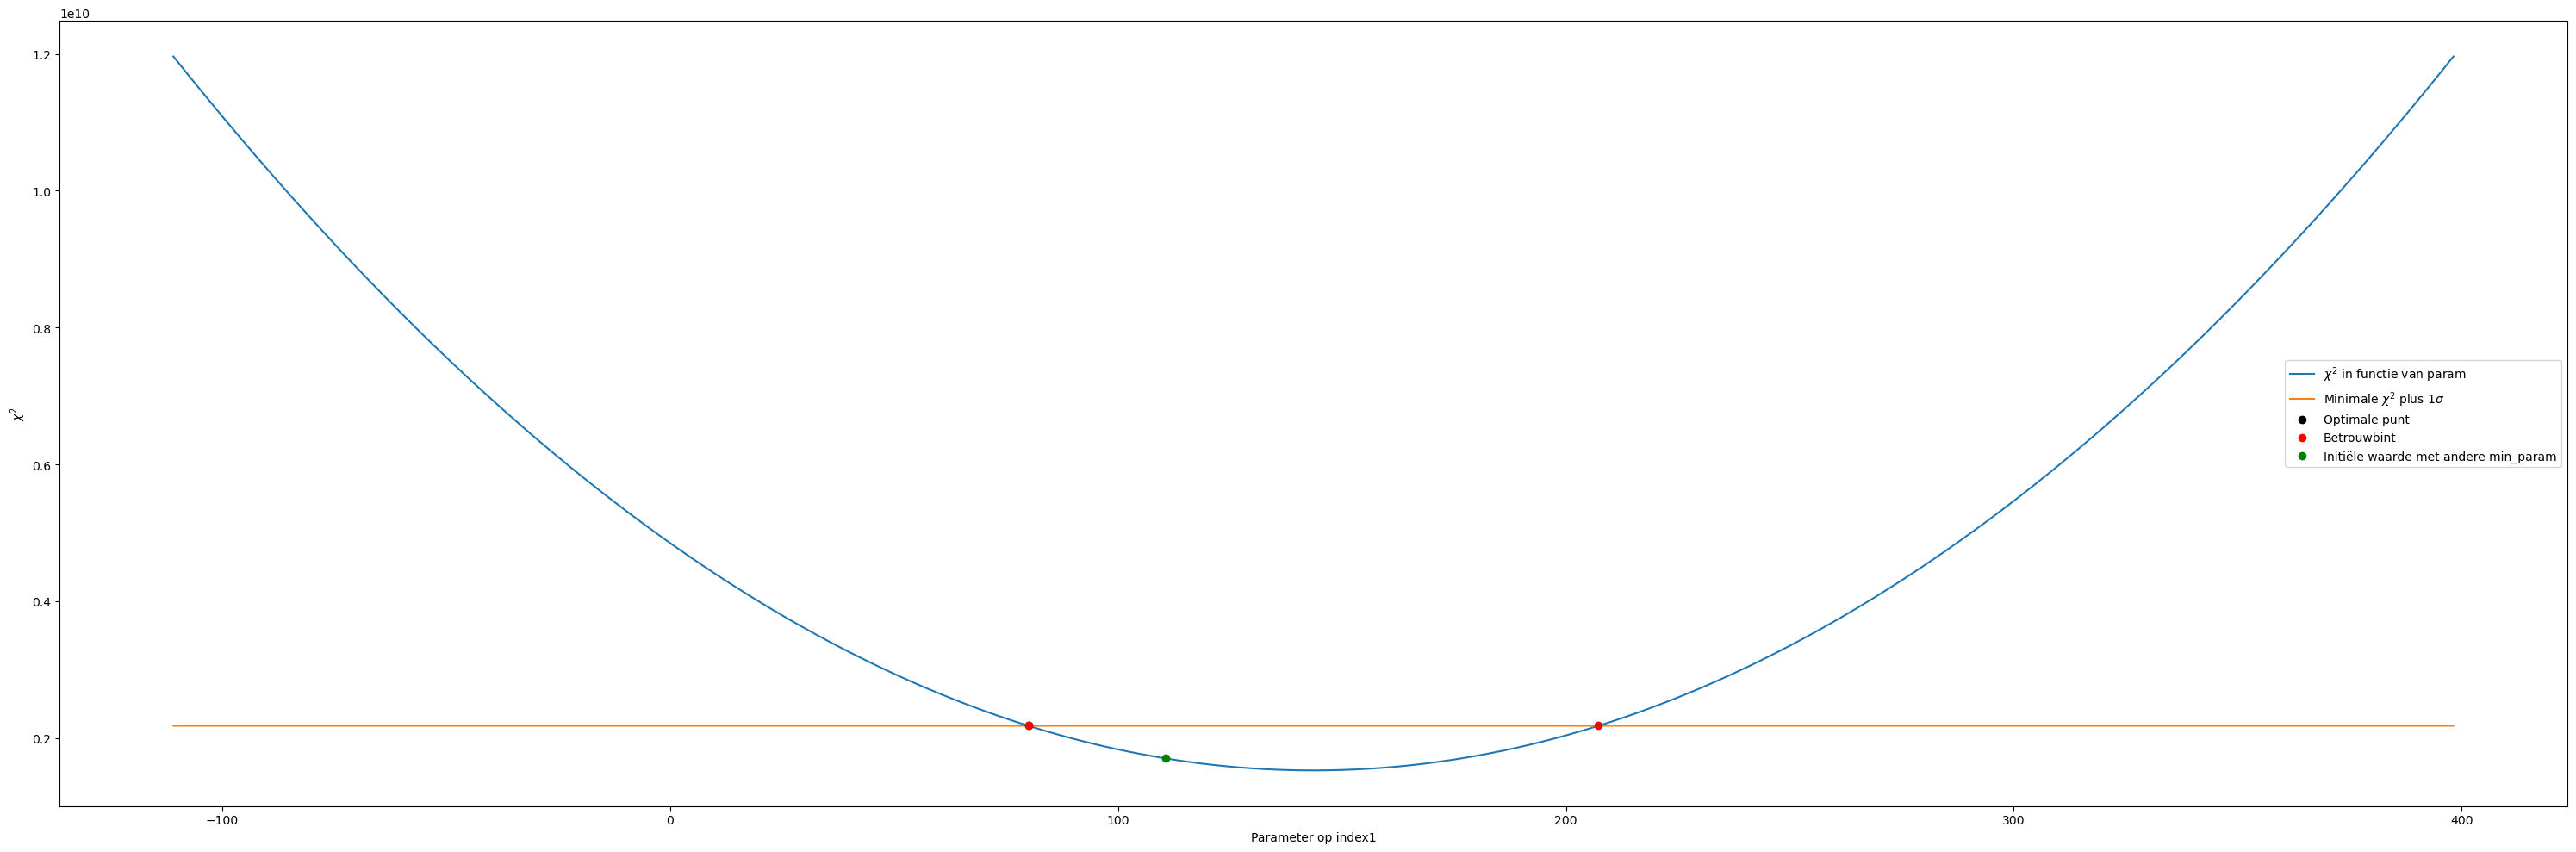

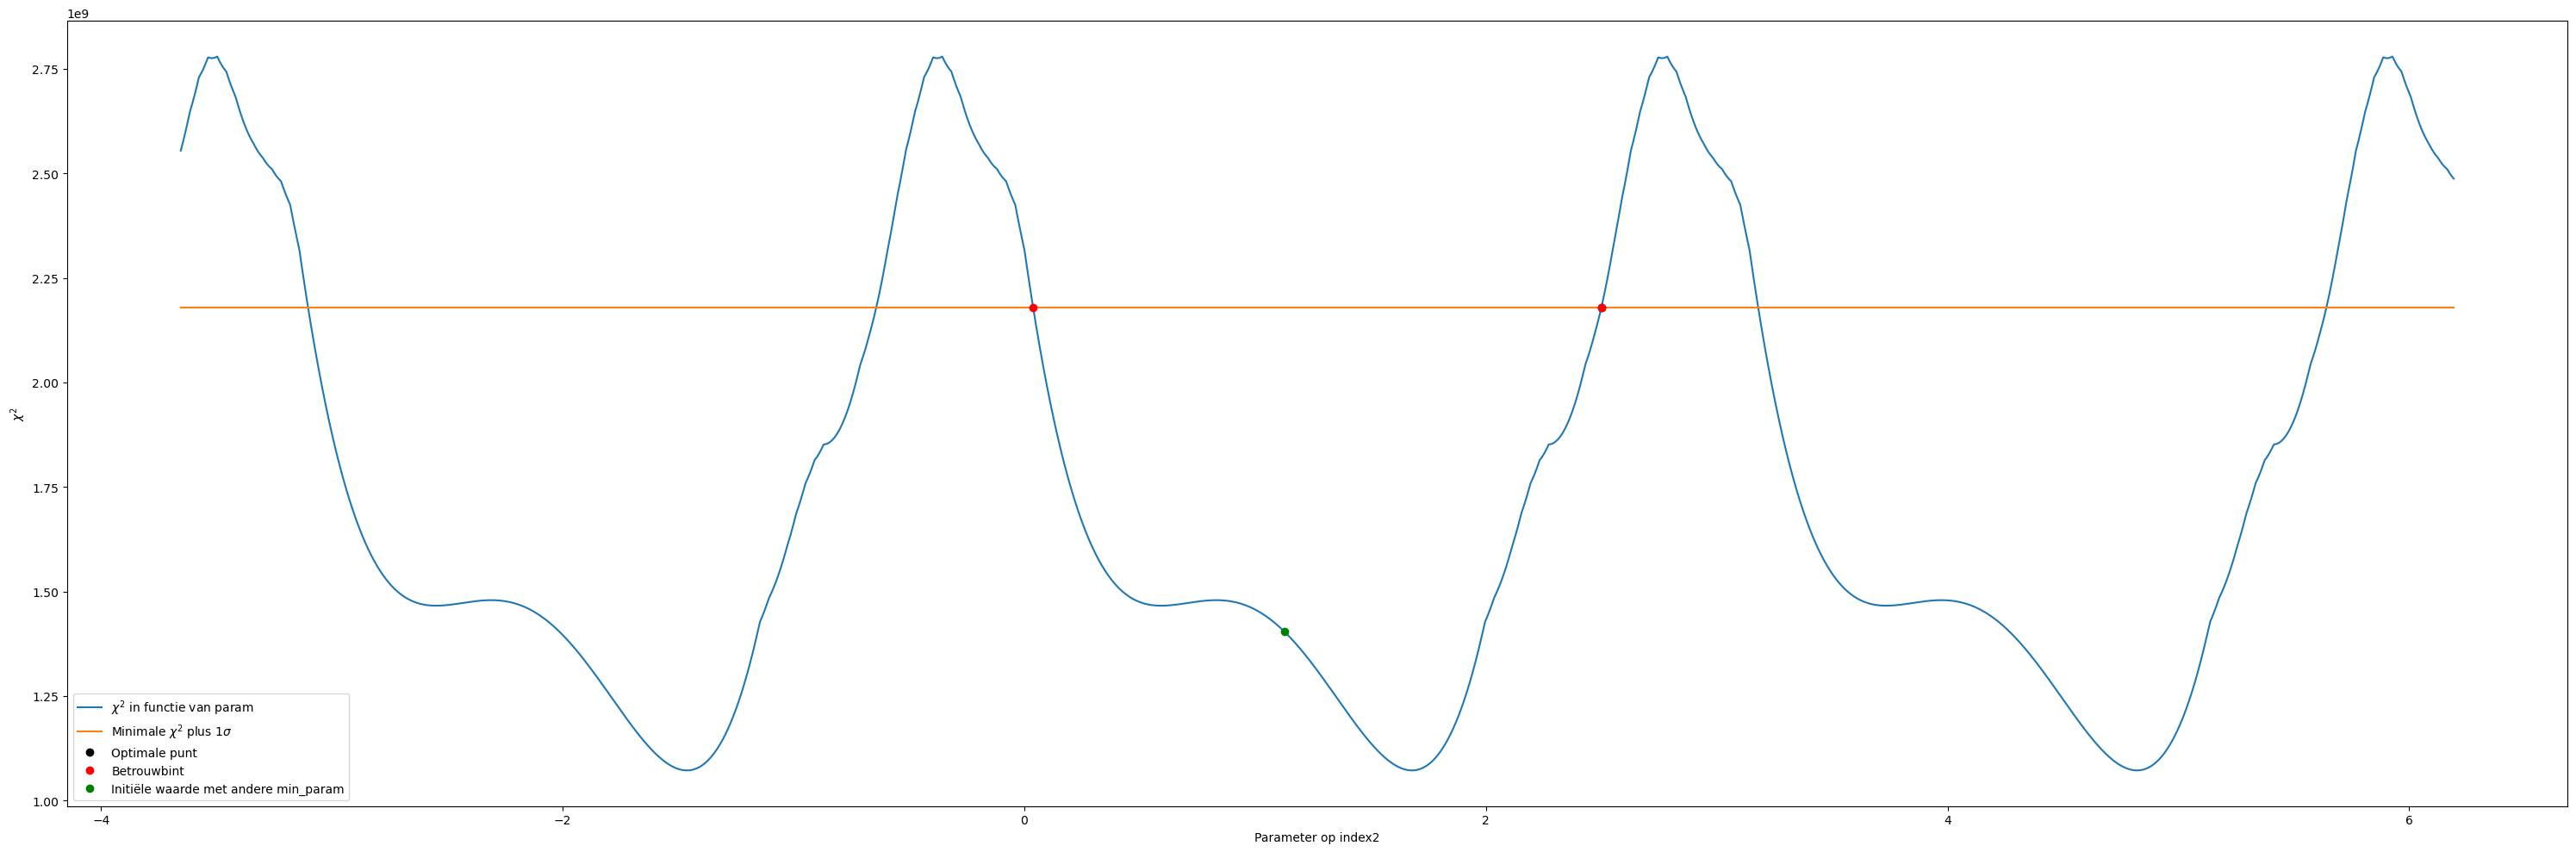

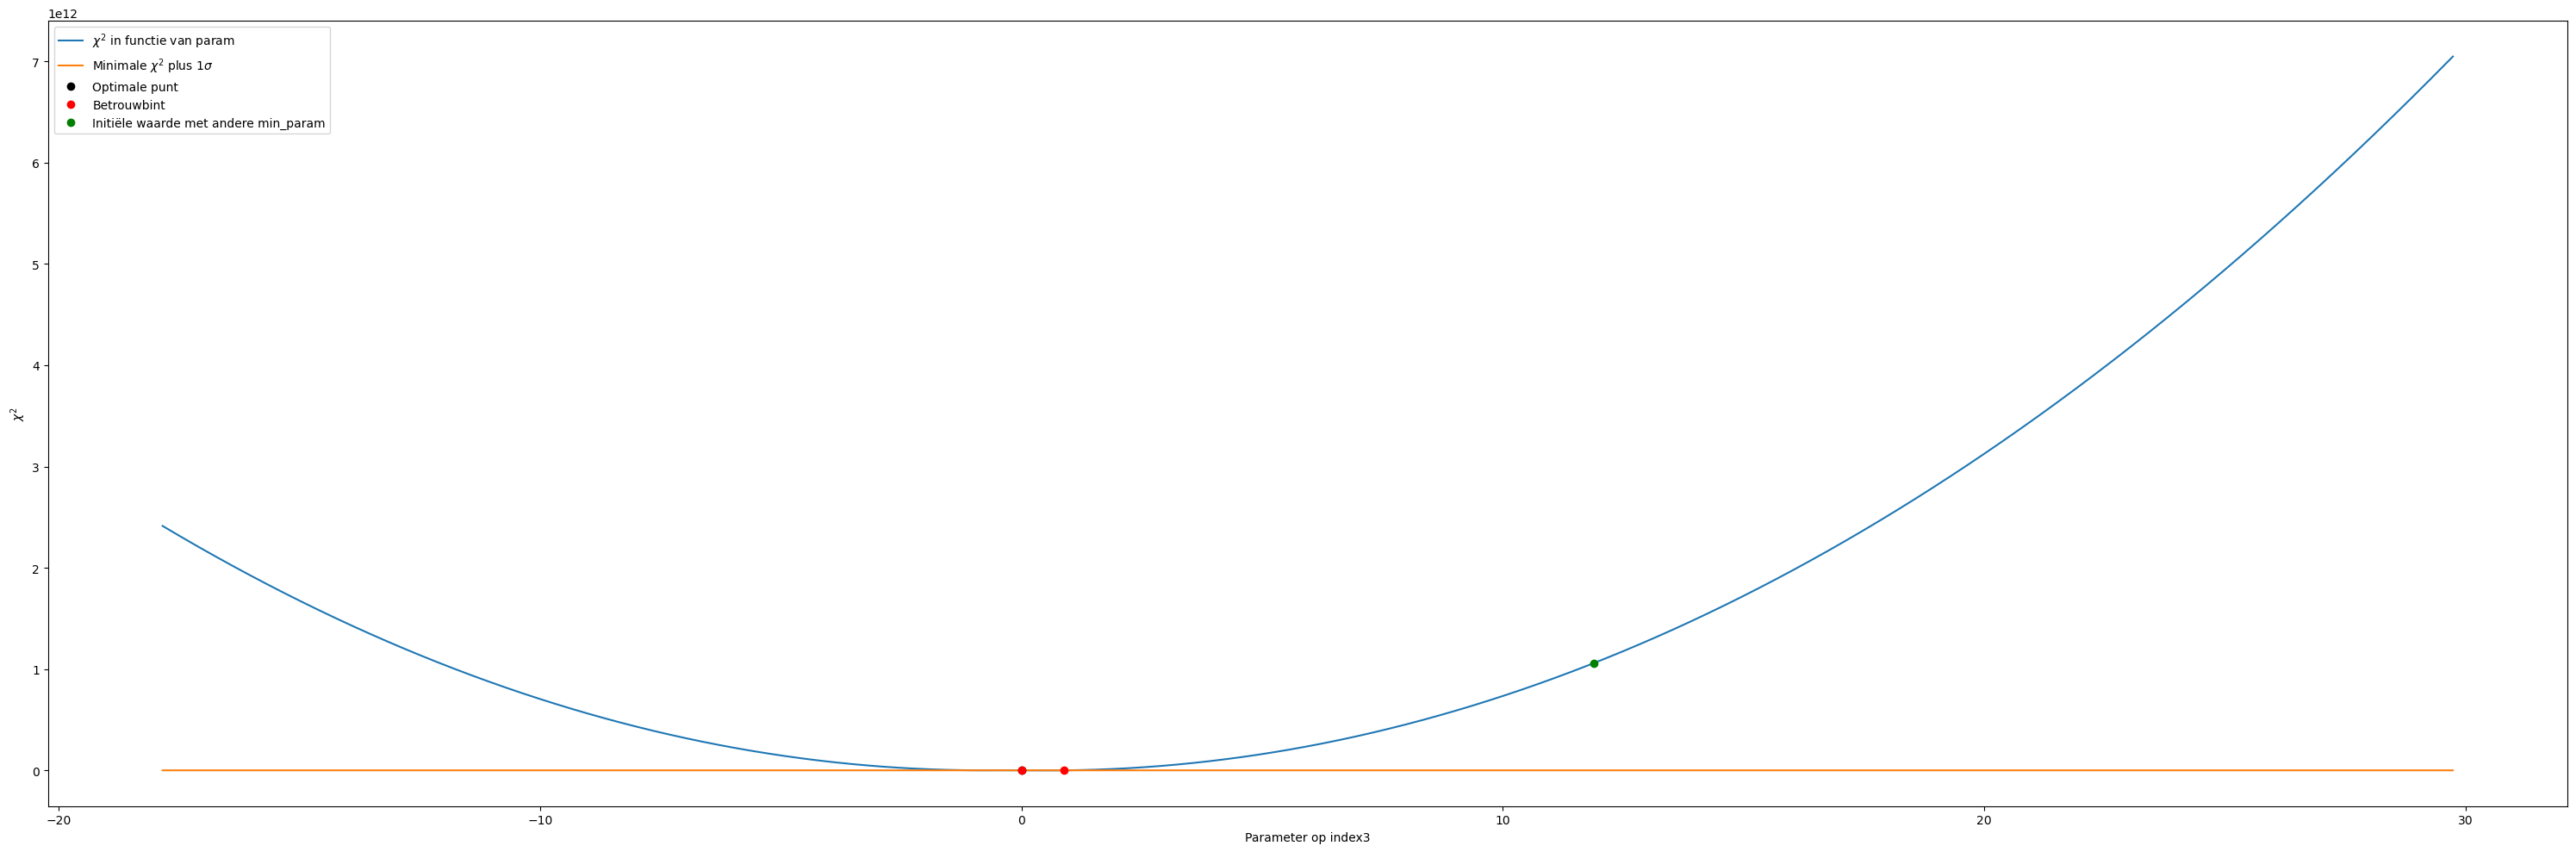

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 1.0896e+08


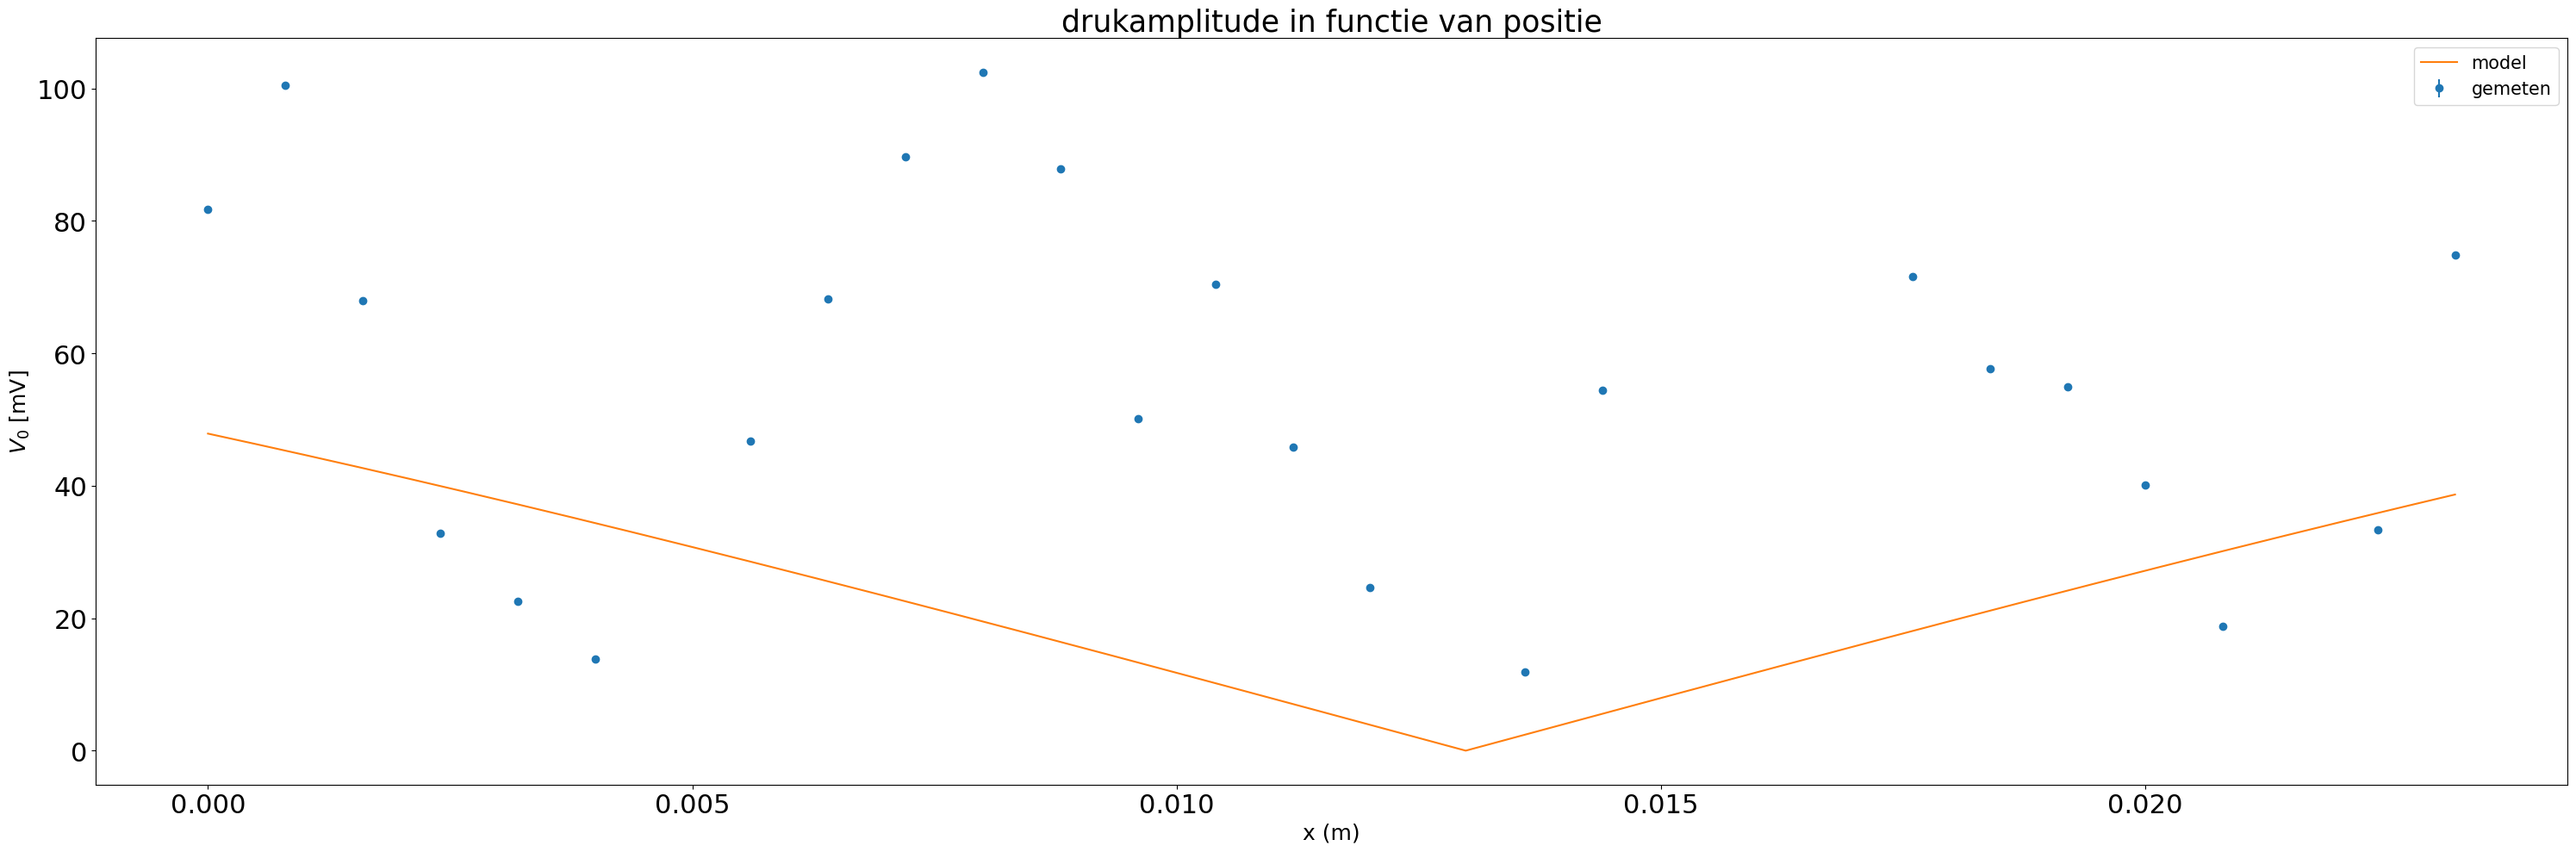

datapunt: v = [252.885022731983, 114.376682746029, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
7
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2165235.2806926

c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\functies.py:252: OptimizeWarning: Initial guess is not within the specified bounds
  mini = minimize(chi2_func, gok, bounds = bounds, args = (x_val, y_val, y_err, soort_fout, model), method="Nelder-Mead")


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2312407117.659467
             x: [ 4.950e+01  1.000e+02  2.080e+00  0.000e+00]
           nit: 121
          nfev: 221
 final_simplex: (array([[ 4.950e+01,  1.000e+02,  2.080e+00,  0.000e+00],
                       [ 4.950e+01,  1.000e+02,  2.080e+00,  0.000e+00],
                       ...,
                       [ 4.950e+01,  1.000e+02,  2.080e+00,  0.000e+00],
                       [ 4.950e+01,  1.000e+02,  2.080e+00,  0.000e+00]]), array([ 2.312e+09,  2.312e+09,  2.312e+09,  2.312e+09,
                        2.312e+09]))
OVERRULED MINIMUM
OVERRULED MINIMUM
OVERRULED MINIMUM
[[49.4999482810195, 49.502034449019504], [89.434900188, 100.000149012], [2.07960562234975, 2.07990364634975], [-0.049173959999999996, 0.000149012]]
k heeft als waarde: 49.501 + 0.0010431 - 0.0010431 met 68% betrouwbaarheidsinterval: [49.5, 49.502] 
p_0 heeft als waarde: 7520 + -7420 - 7430.6 met 68% b

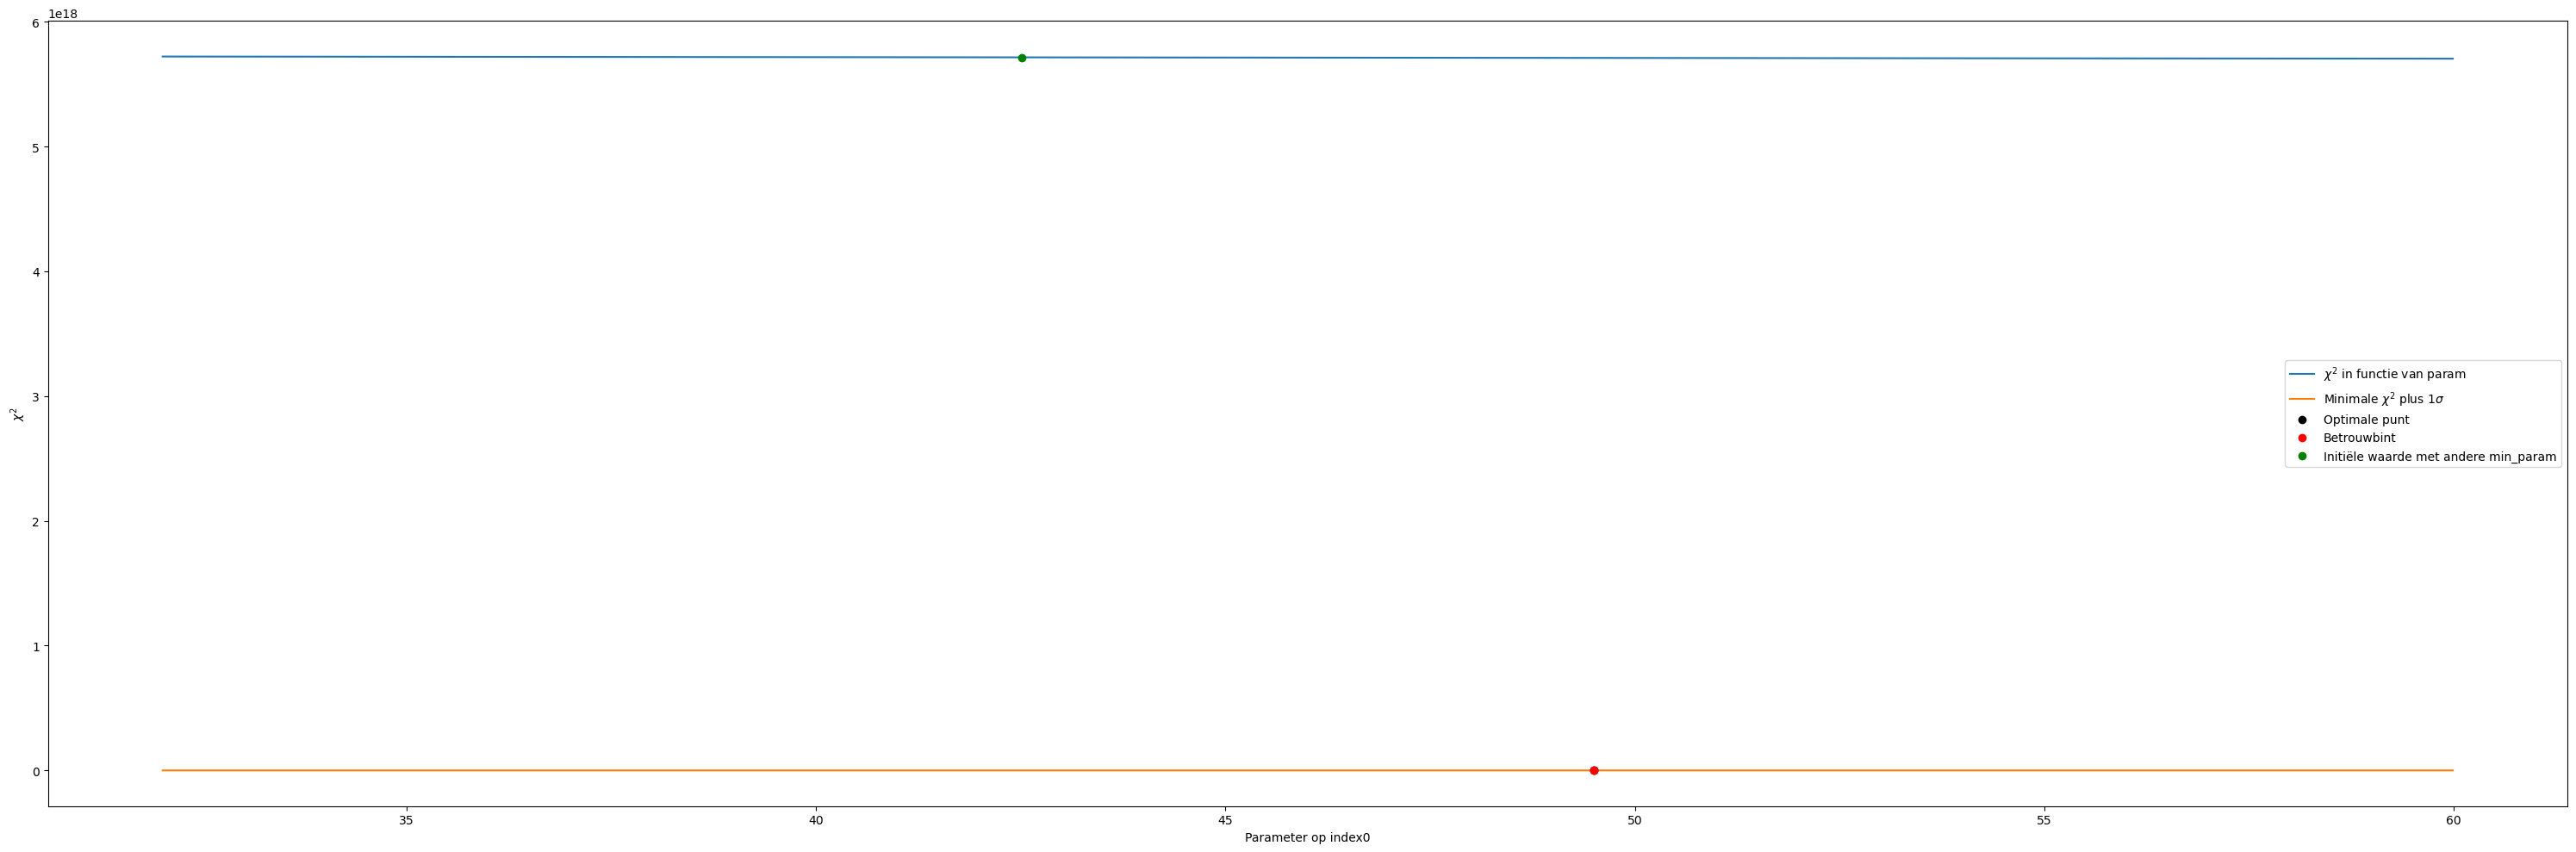

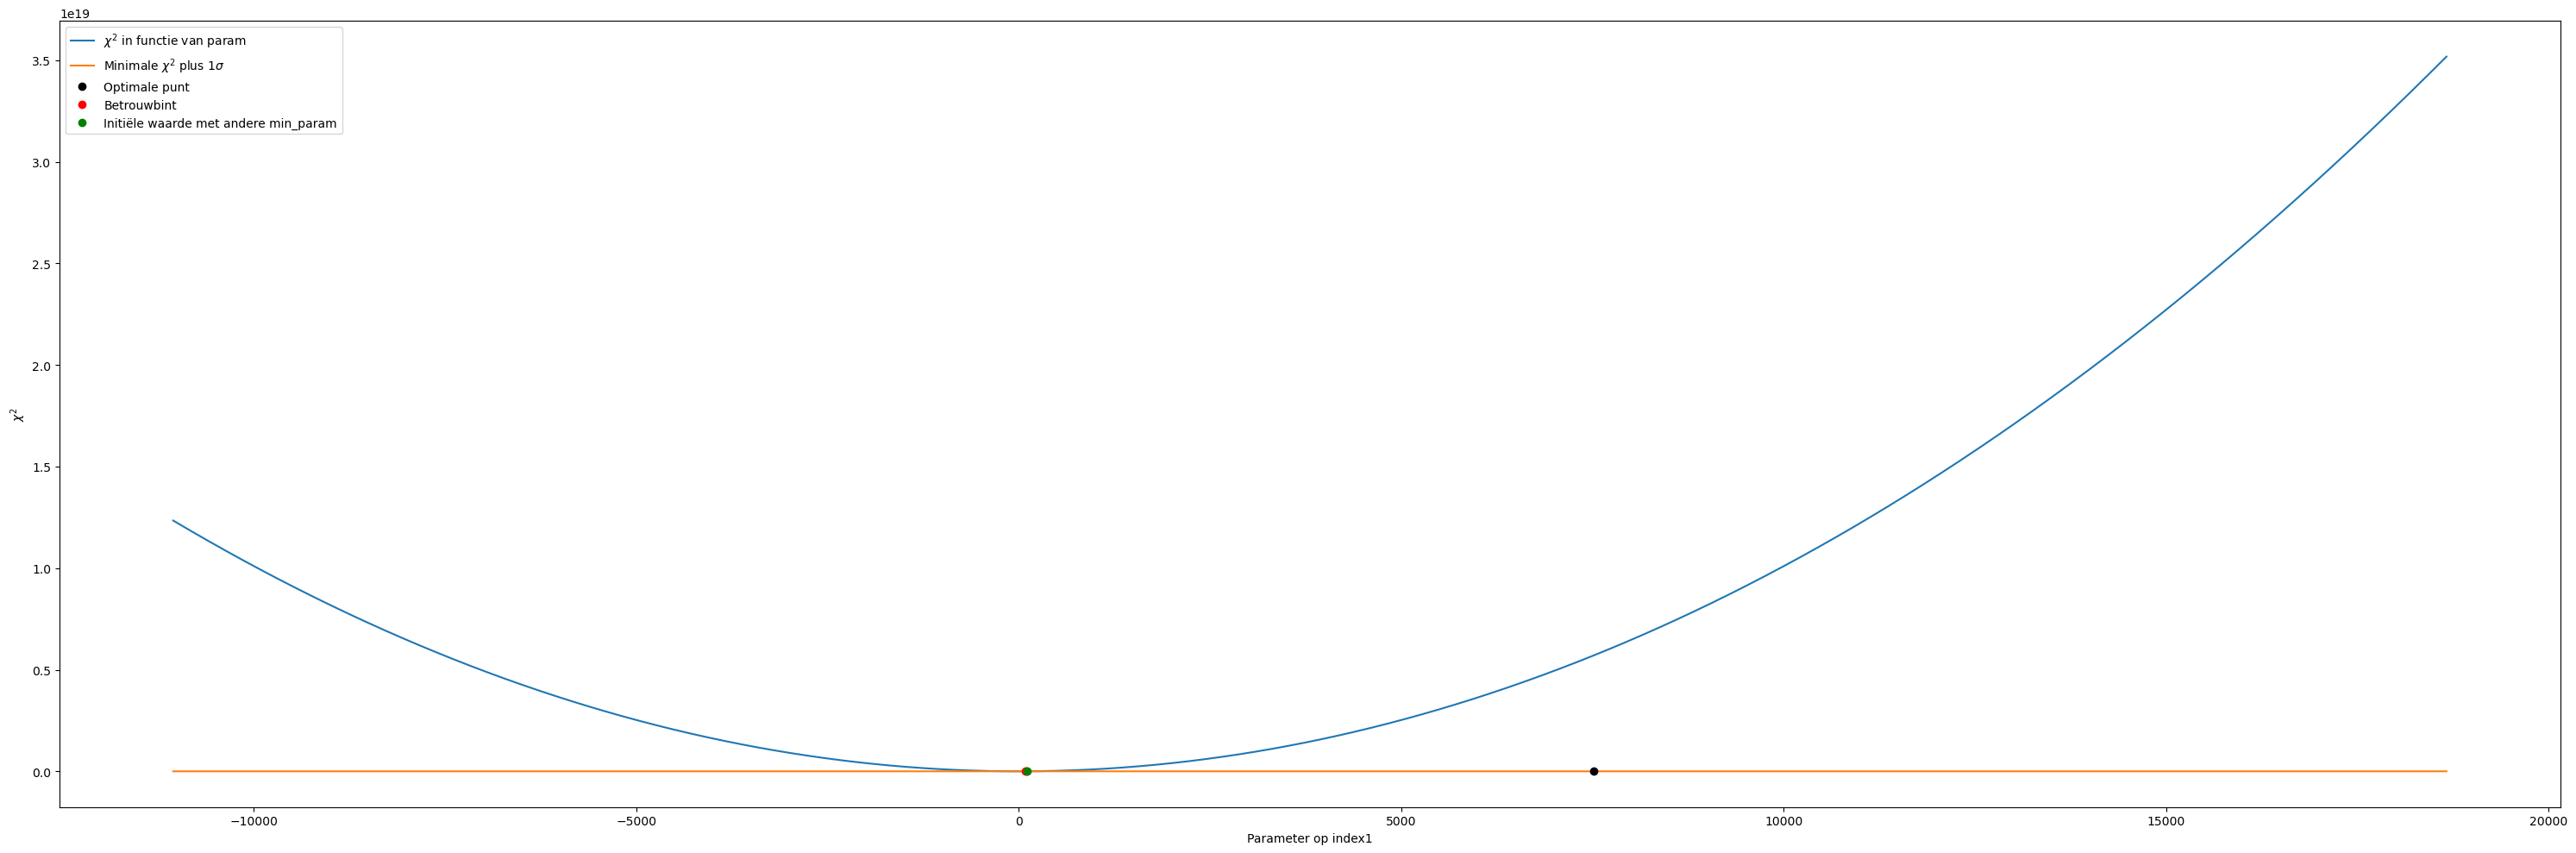

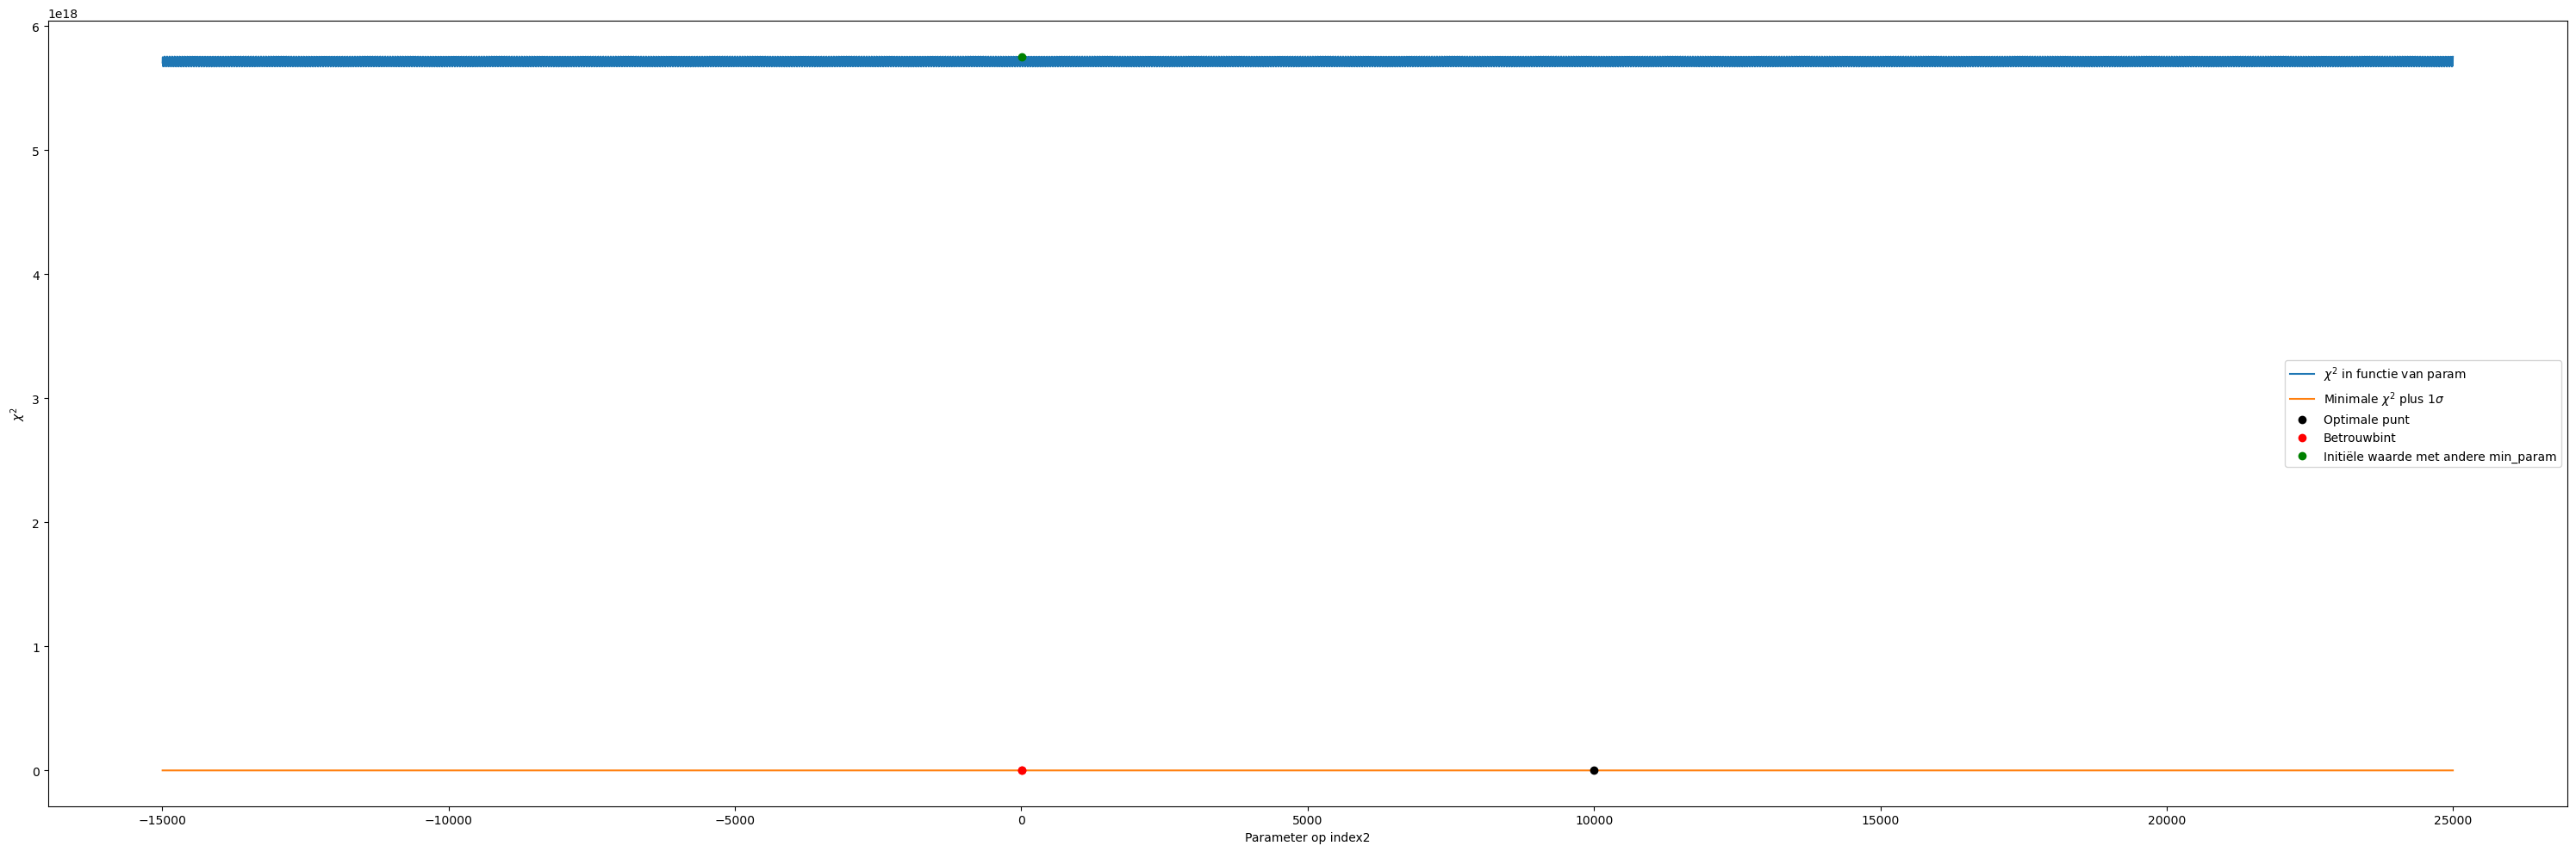

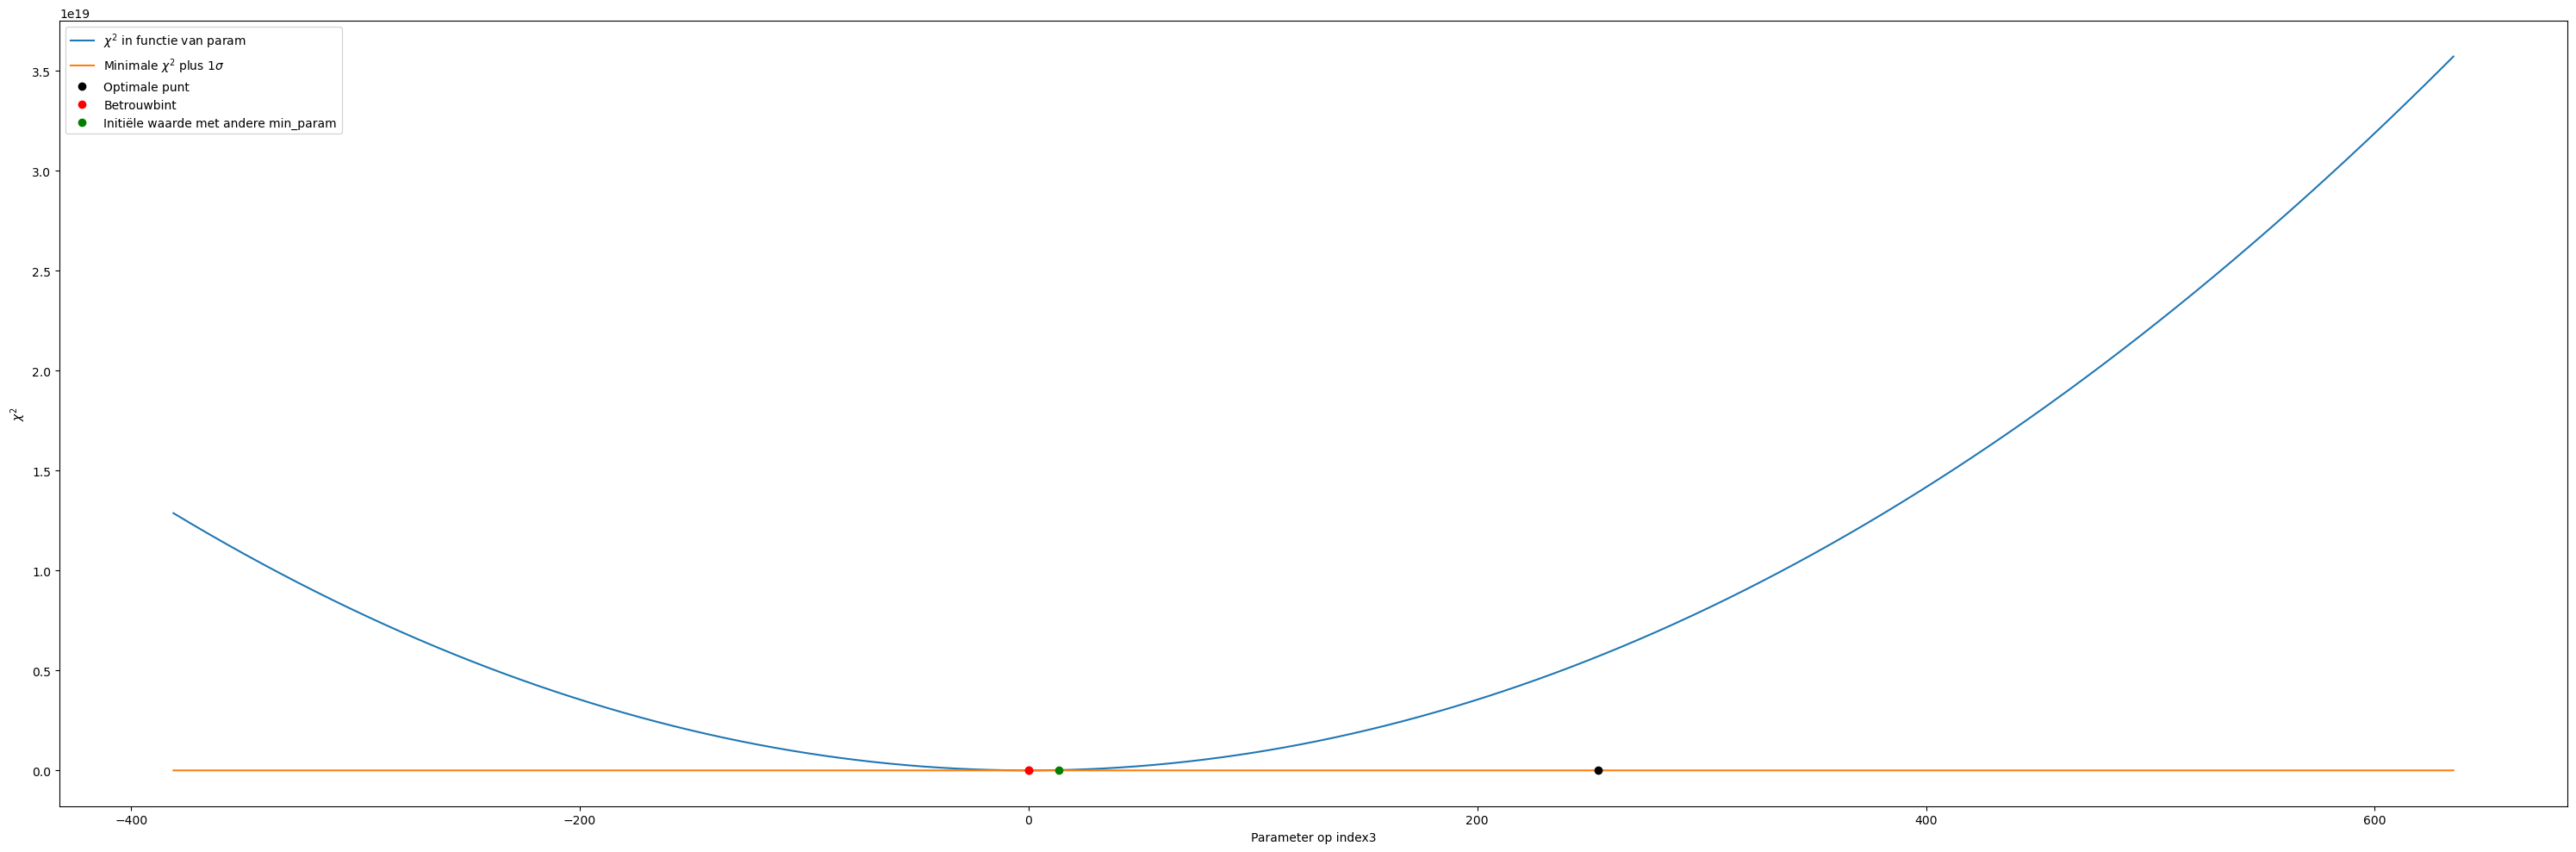

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 9.2496e+07


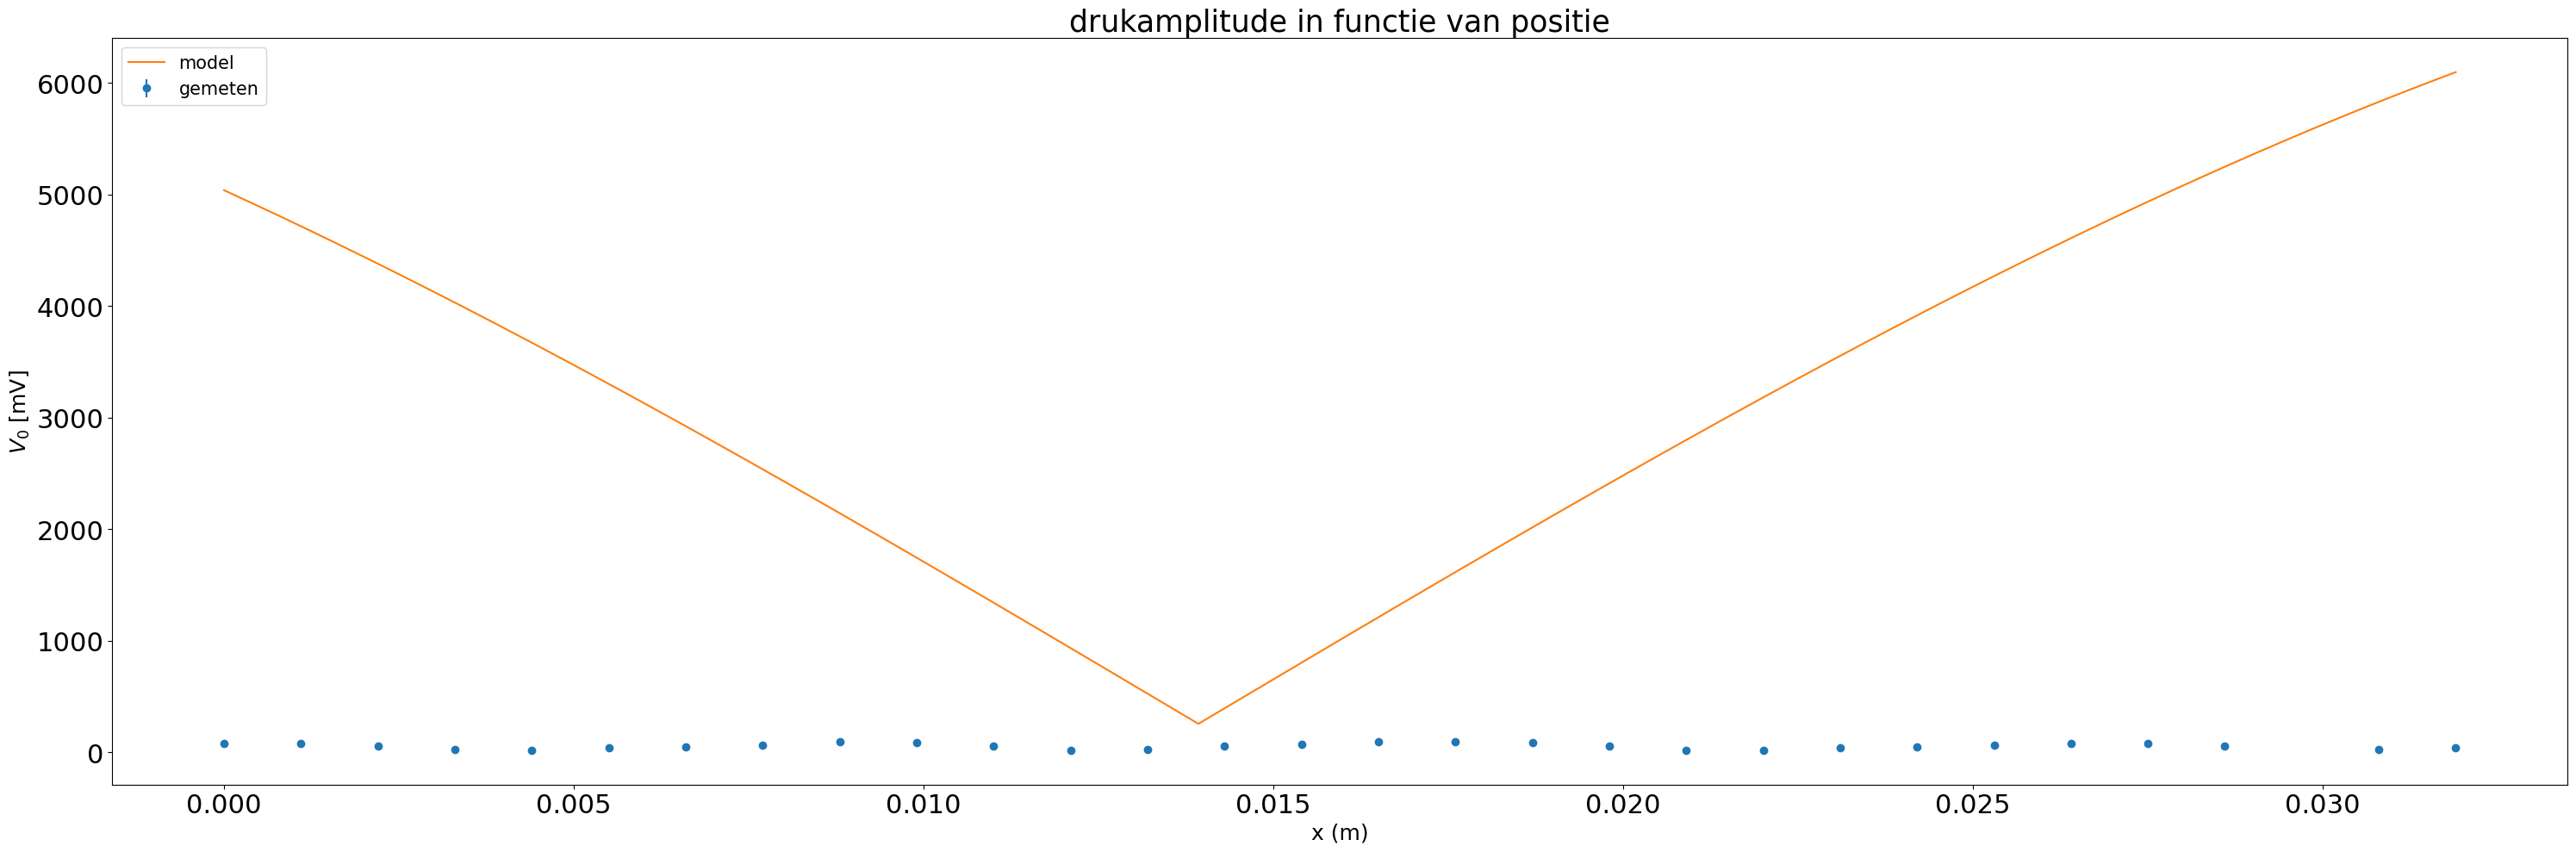

datapunt: v = [251.176928033560, 204.357779842276, 'Normaal']


C:\Users\User\AppData\Local\Temp\ipykernel_4948\1135016816.py:49: RuntimeWarning: invalid value encountered in arcsin
  phi = np.pi - np.arcsin((Vpart[0] - C)/amplitude)


FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
1
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2856447.181811219
             x: [ 1.240e-01  8.013e+01  1.598e+00  1.289e+01]
           nit: 175
          nfev: 310
 final_simplex: (array([[ 1.240e-01,  8.013e+01,  1.598e+00,  1.289e+01],
                       [ 1.240e-01,  8.013e+01,  1.598e+00,  1.289e+01],
                       ...,
                       [ 1.240e-01,  8.013e+01,  1.598e+00,  1.289e+01],
      

C:\Users\User\AppData\Local\Temp\ipykernel_4948\3510727045.py:105: RuntimeWarning: invalid value encountered in arcsin
  phigok = np.arcsin(P_0_x[0]/(maximum - minimum)) - Kgok*X[0]


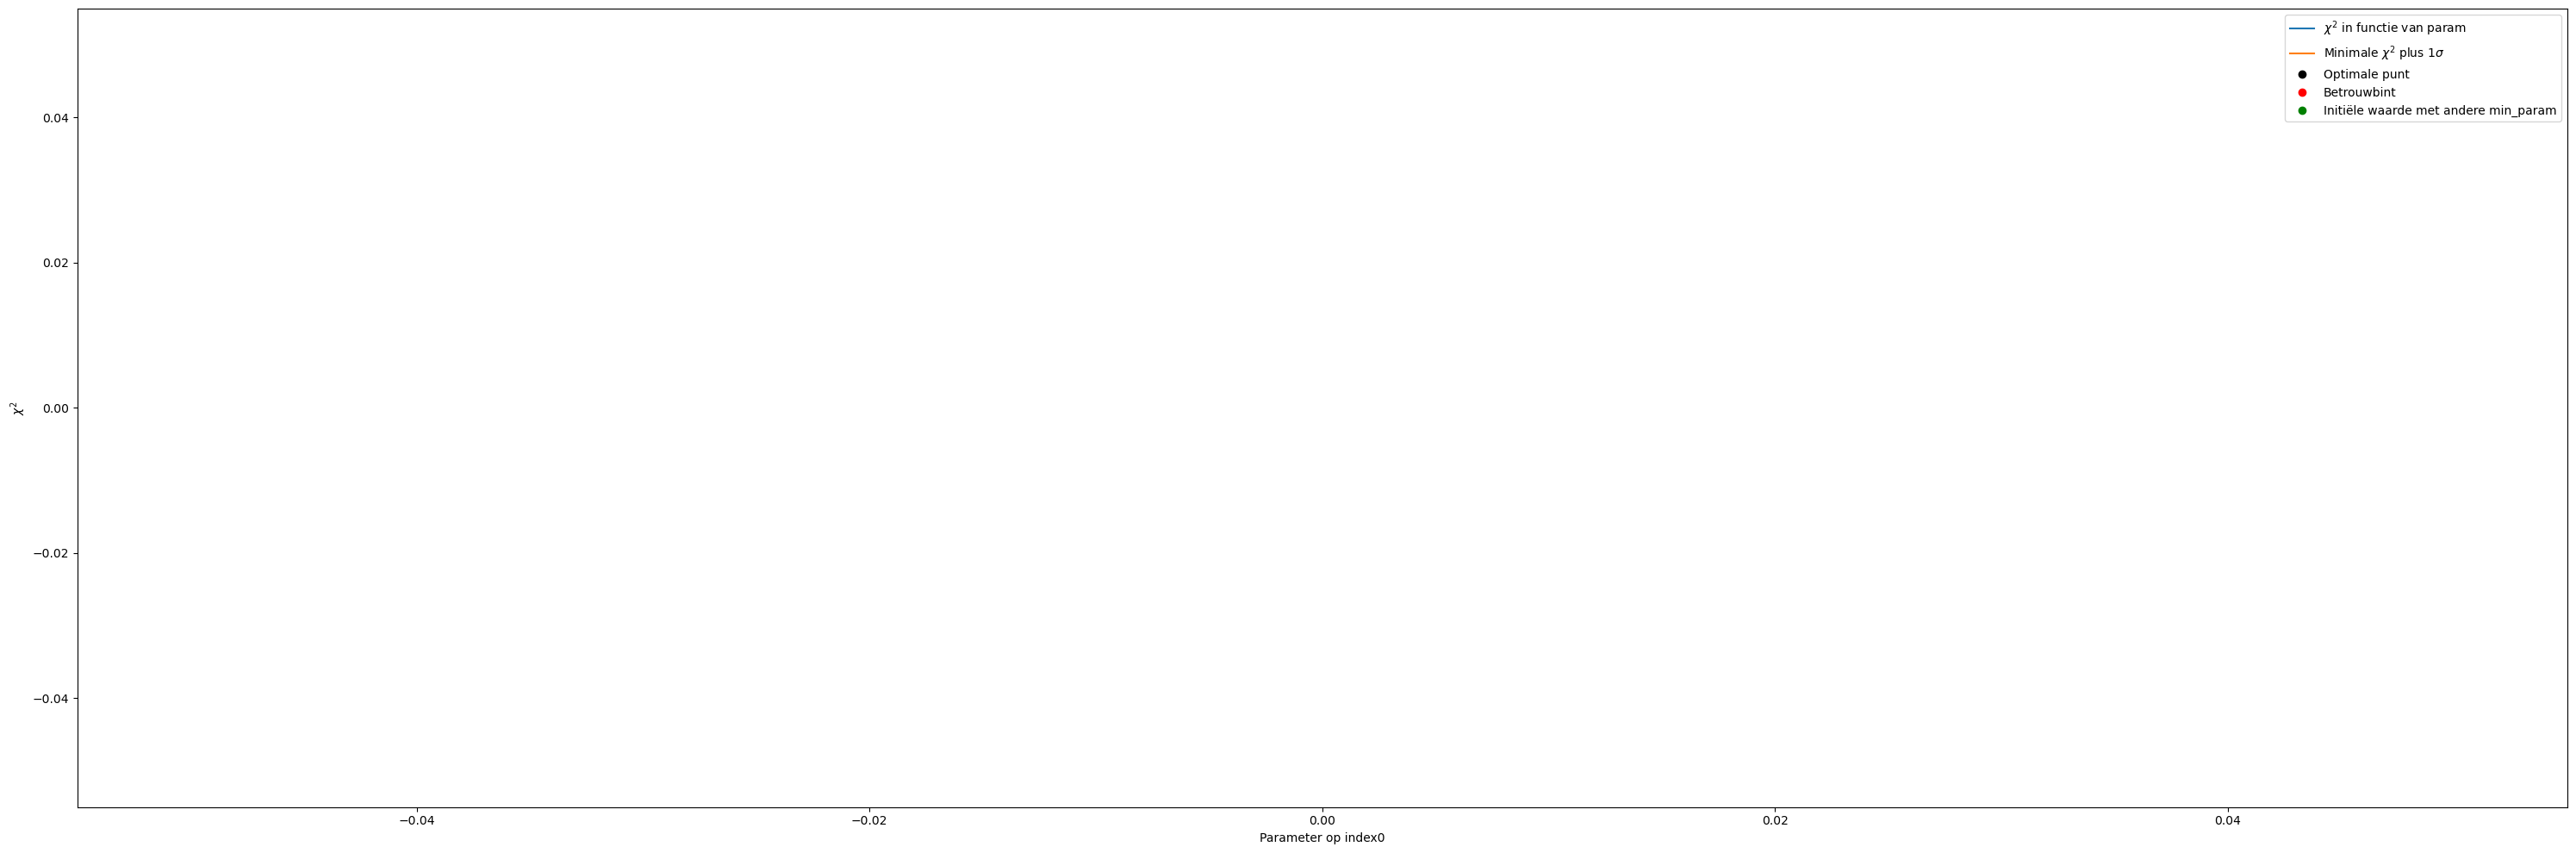

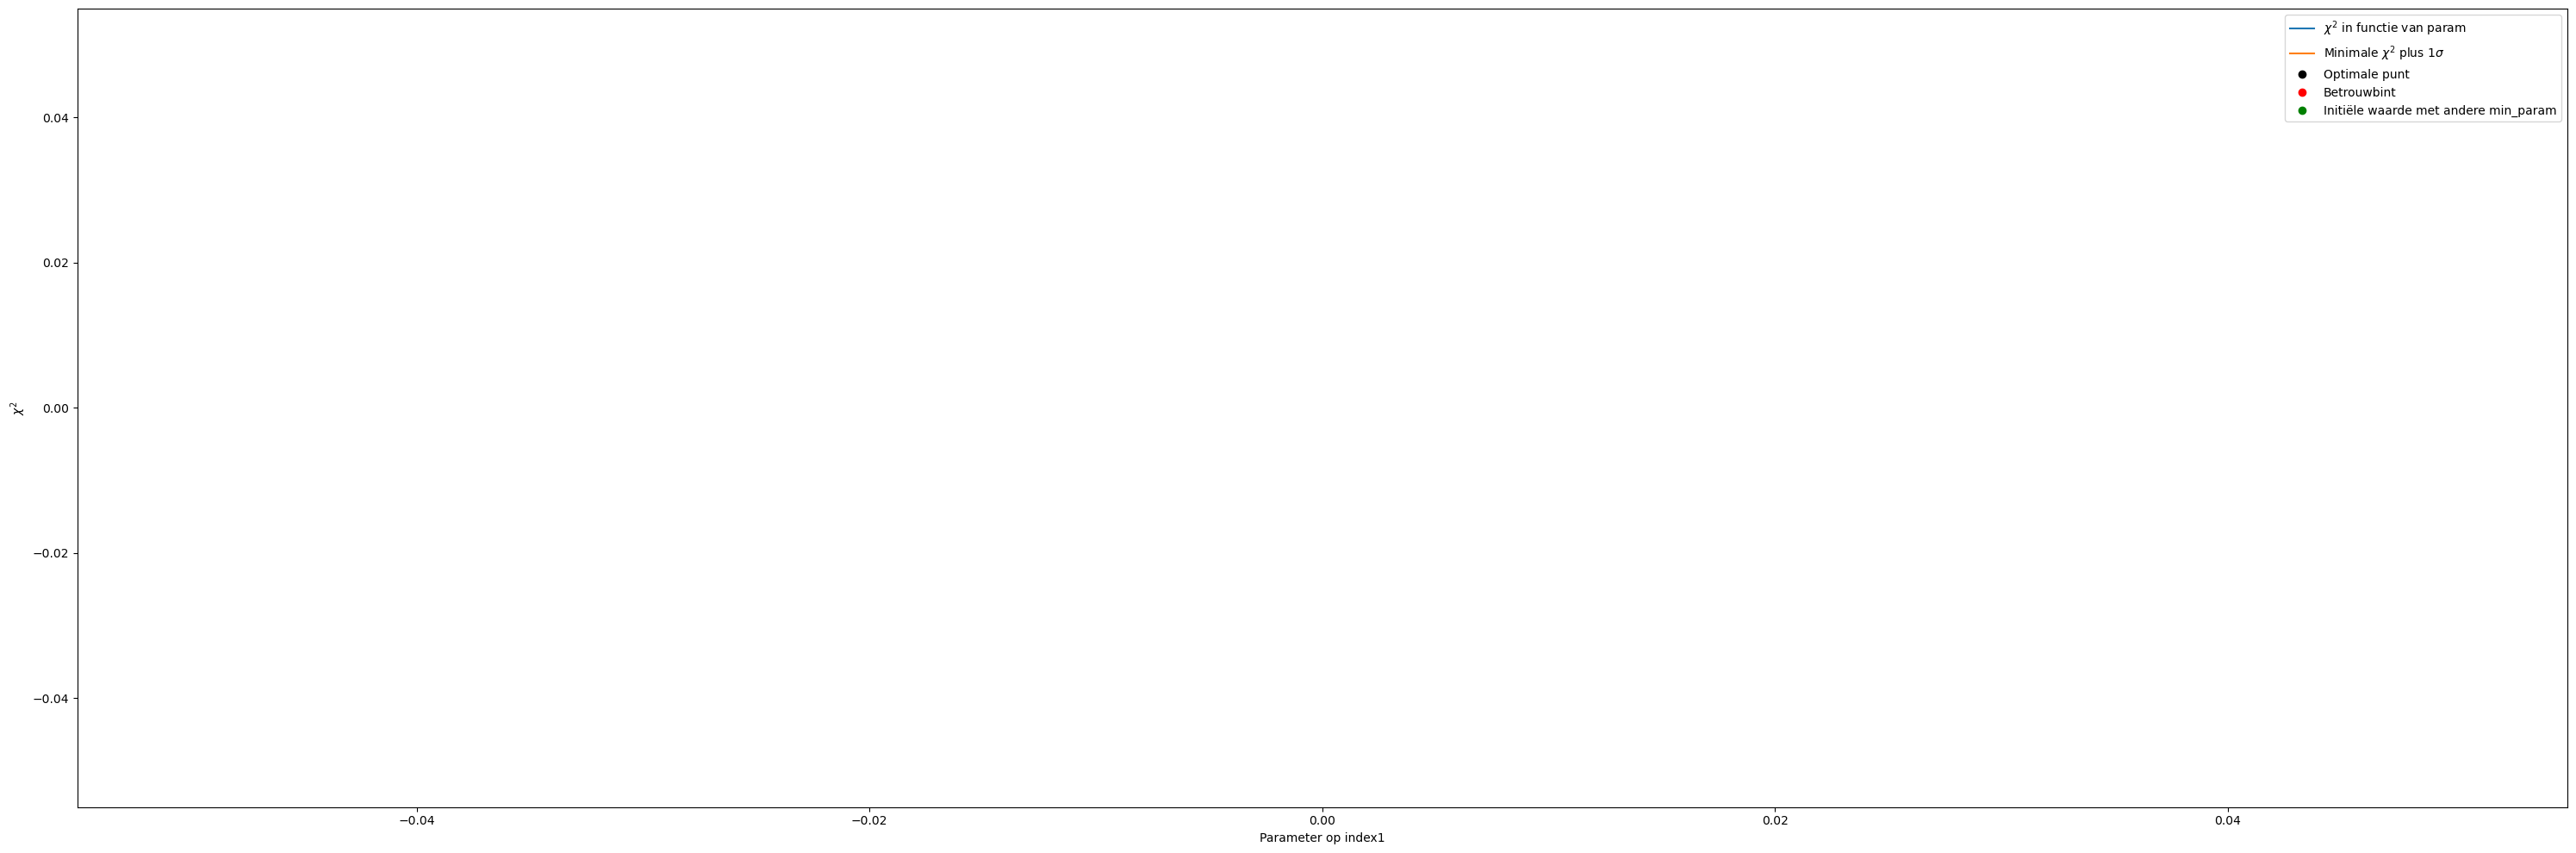

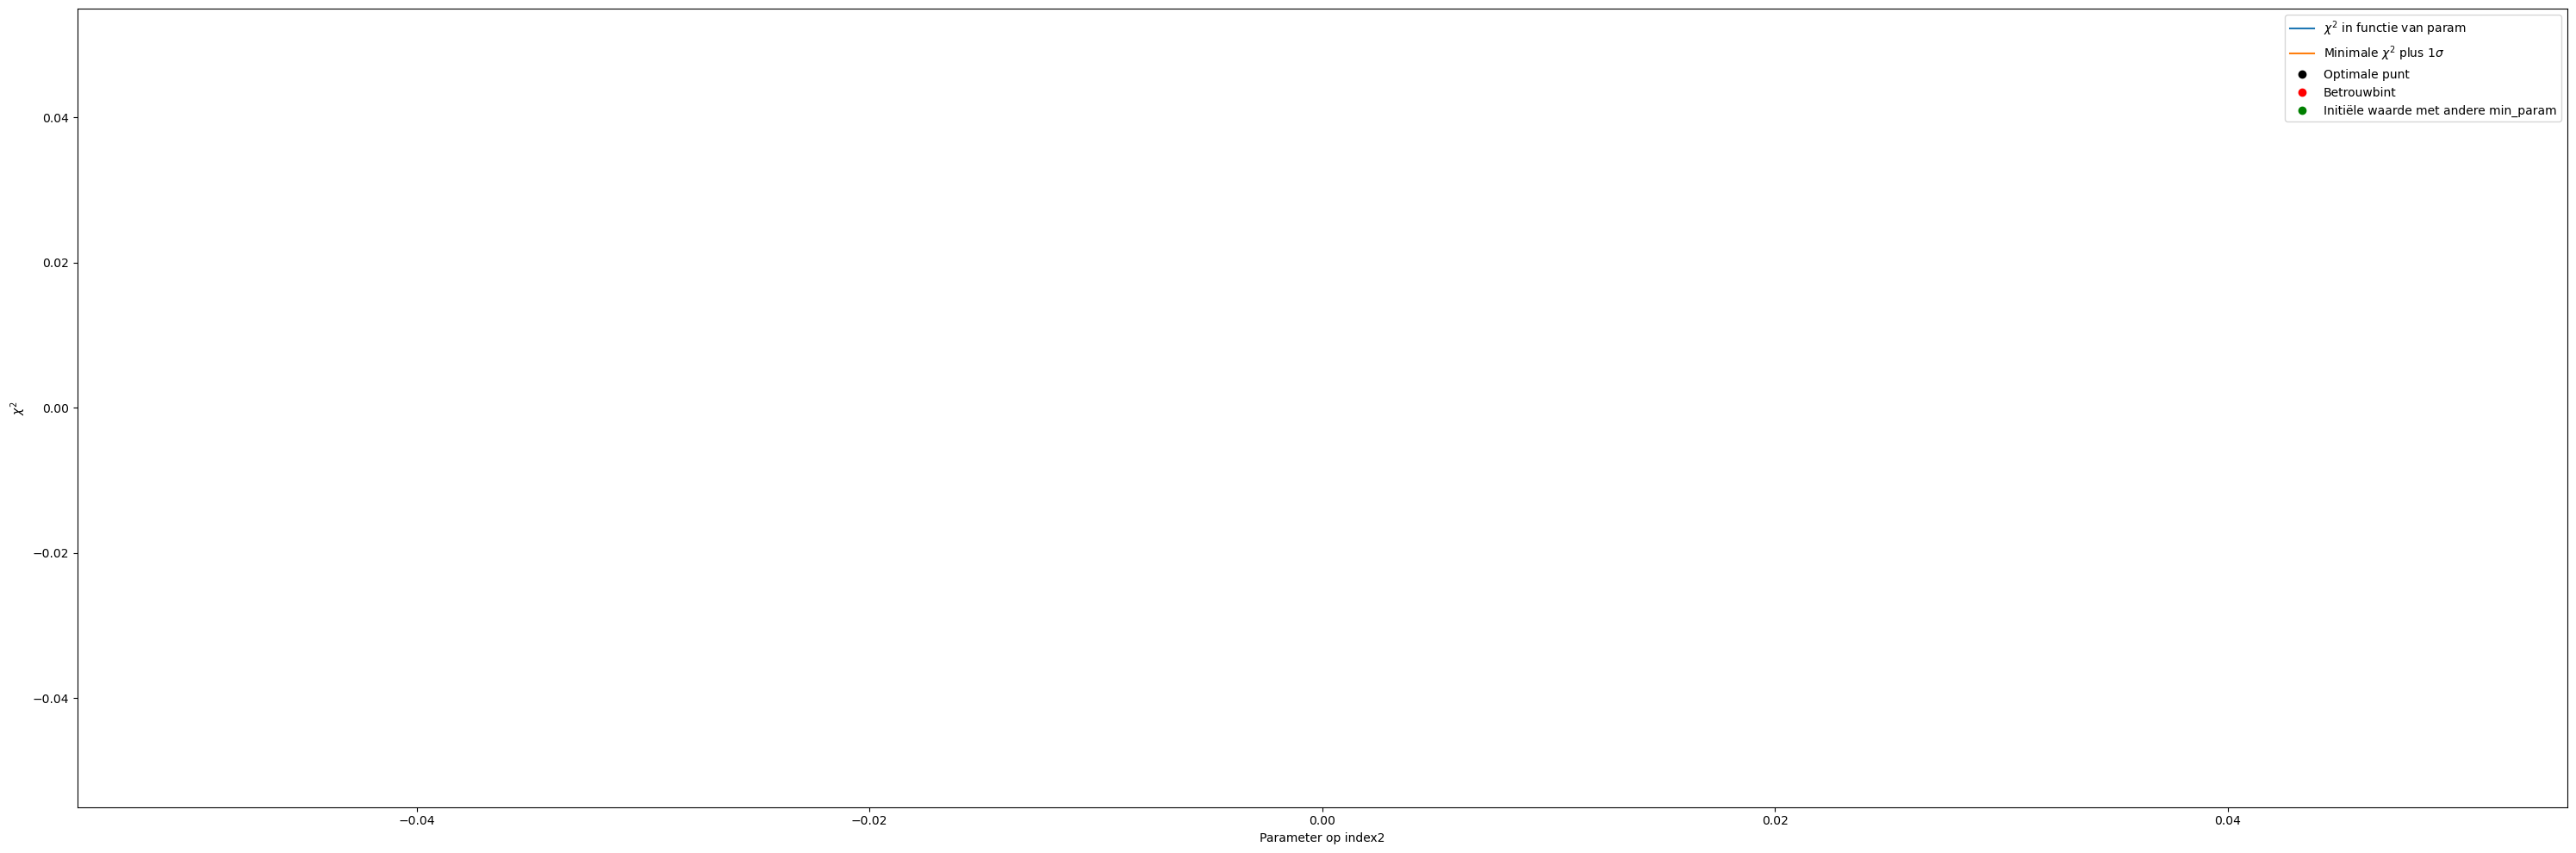

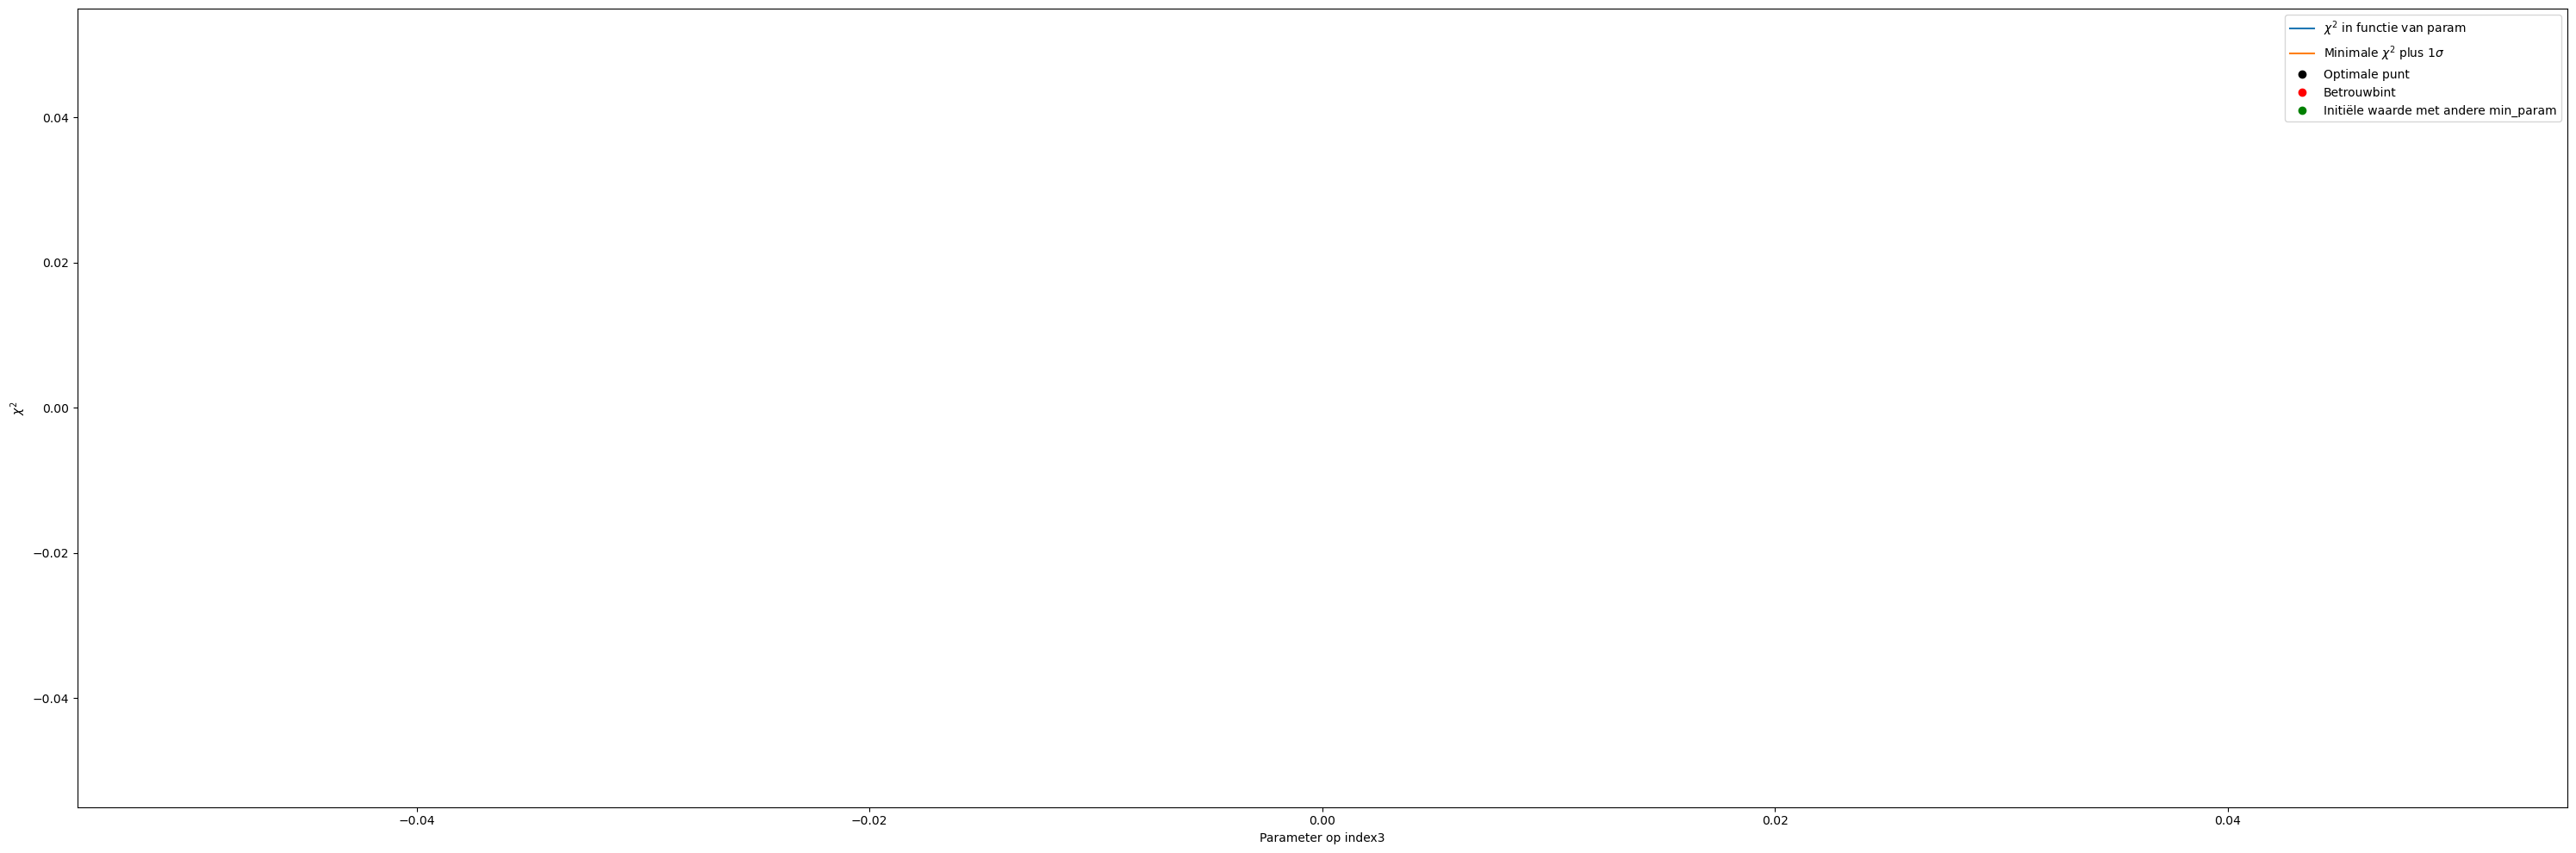

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: nan
De gereduceerde chi^2 waarde is: nan


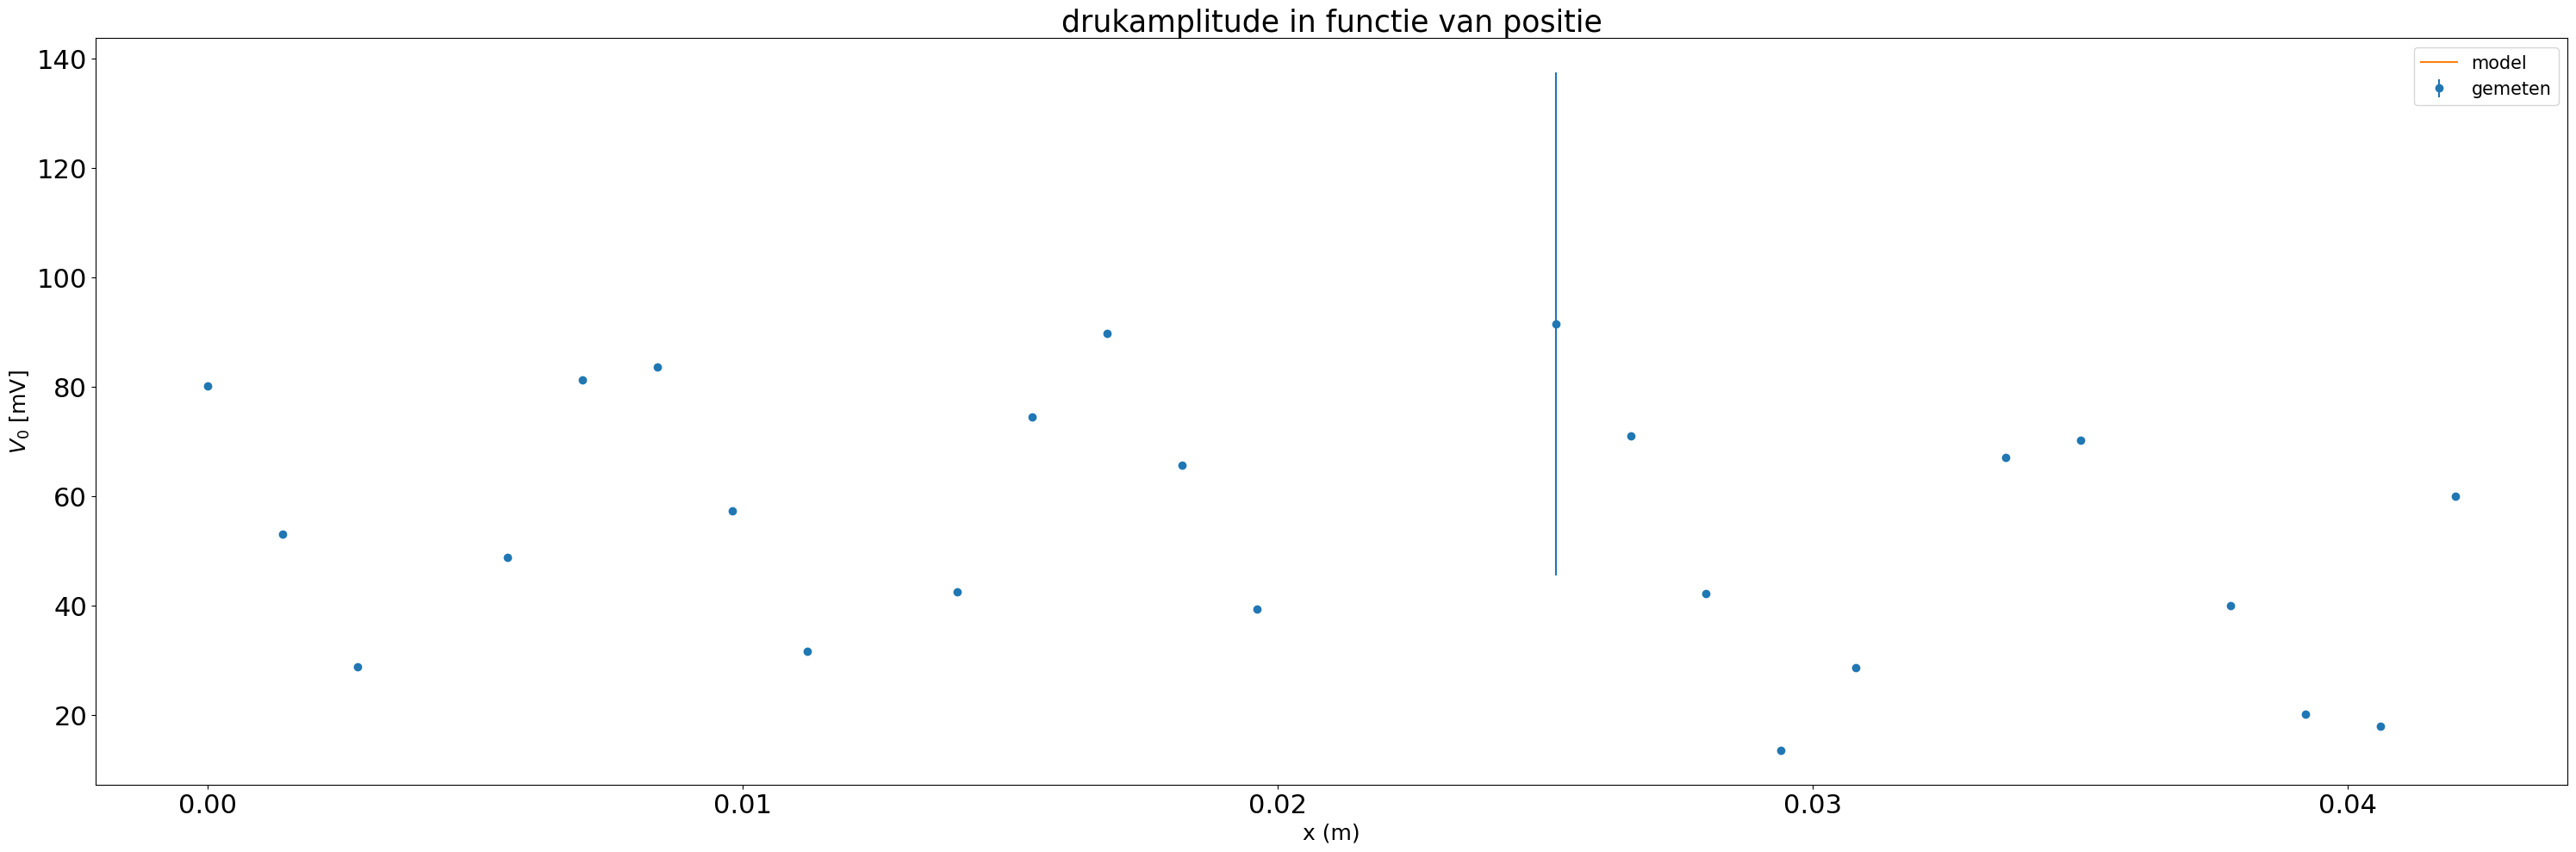

datapunt: v = [366.511484526058, 247.927757782109, 'Normaal']
________met de 3 experimenten samen:_______
datapunt: v = [251.359510845212, 74.8043067293812, 'Normaal']


In [ ]:
#de experimenten op 2000Hz

lengtes = ['26.1', '35.0', '44.1']
stappen = [0.8, 1.1, 1.4] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 330, 430]
gokranges = [[(35, 50), (80, 120), (1,2), (0,20)], [(35.0, 50), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)], [(35.0, 50), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [False, True, False]
CPUfuggin = [True, True, False]
Kwaardes = []
omegawaardes = []
for indx in range(len(lengtes)):
    lengte = lengtes[indx]
    mypath = "metingen laweit/2000Hz, "+lengte+"cm"
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
                                             detailed_logs=True, print_tijdfit = False, fit_x_vals=True, fuck_CPU = CPUfuggin[indx], saveto = mypath)
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')
print(snelheid)

FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
3
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5464355712.463674
             x: [ 1.228e+02  1.215e-01  2.461e+00  6.288e+00]
           nit: 400
          nfev: 689
 final_simplex: (array([[ 1.228e+02,  1.215e-01,  2.461e+00,  6.288e+00],
                       [ 1.228e+02,  1.215e-01,  2.461e+00,  6.288e+00],

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 248829169.52840865
             x: [ 1.938e+02 -4.188e-02 -1.924e+00  1.302e+01]
           nit: 281
          nfev: 509
 final_simplex: (array([[ 1.938e+02, -4.188e-02, -1.924e+00,  1.302e+01],
                       [ 1.938e+02, -4.189e-02, -1.924e+00,  1.302e+01],
                       ...,
                       [ 1.938e+02, -4.188e-02, -1.924e+00,  1.302e+01],
                       [ 1.938e+02, -4.188e-02, -1.924e+00,  1.302e+01]]), array([ 2.488e+08,  2.488e+08,  2.488e+08,  2.488e+08,
                        2.488e+08]))
[[96.87772047318819, 290.6314251954865], [-0.037546825370950304, -0.04621380015652741], [-1.741356535832418, -1.9827282531152421], [13.016856515437583, 13.022986086705973]]
omega heeft als waarde: 193.75 + 96.877 - 96.877 met 68% betrouwbaarheidsinterval: [96.878, 290.63] 
p_0_x heeft als waarde: -0.041884 + -0.0043296 - -0.0043374 met 68% betrouwbaarhe

c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\functies.py:252: OptimizeWarning: Initial guess is not within the specified bounds
  mini = minimize(chi2_func, gok, bounds = bounds, args = (x_val, y_val, y_err, soort_fout, model), method="Nelder-Mead")


OVERRULED MINIMUM
OVERRULED MINIMUM
OVERRULED MINIMUM
OVERRULED MINIMUM
[[19.726126032000003, 50.000149012], [-99.38014216799999, 100.000149012], [-0.2879338505046776, -0.2876358265046776], [-0.000149012, 0.0017881439999999998]]
k heeft als waarde: 3823 + -3773 - 3803.3 met 68% betrouwbaarheidsinterval: [19.726, 50] 
p_0 heeft als waarde: 7421 + -7321 - 7520.4 met 68% betrouwbaarheidsinterval: [-99.38, 100] 
phi heeft als waarde: 9988 + -9988.3 - 9988.3 met 68% betrouwbaarheidsinterval: [-0.28793, -0.28764] 
C heeft als waarde: 9999 + -9999 - 9999 met 68% betrouwbaarheidsinterval: [-0.00014901, 0.0017881] 


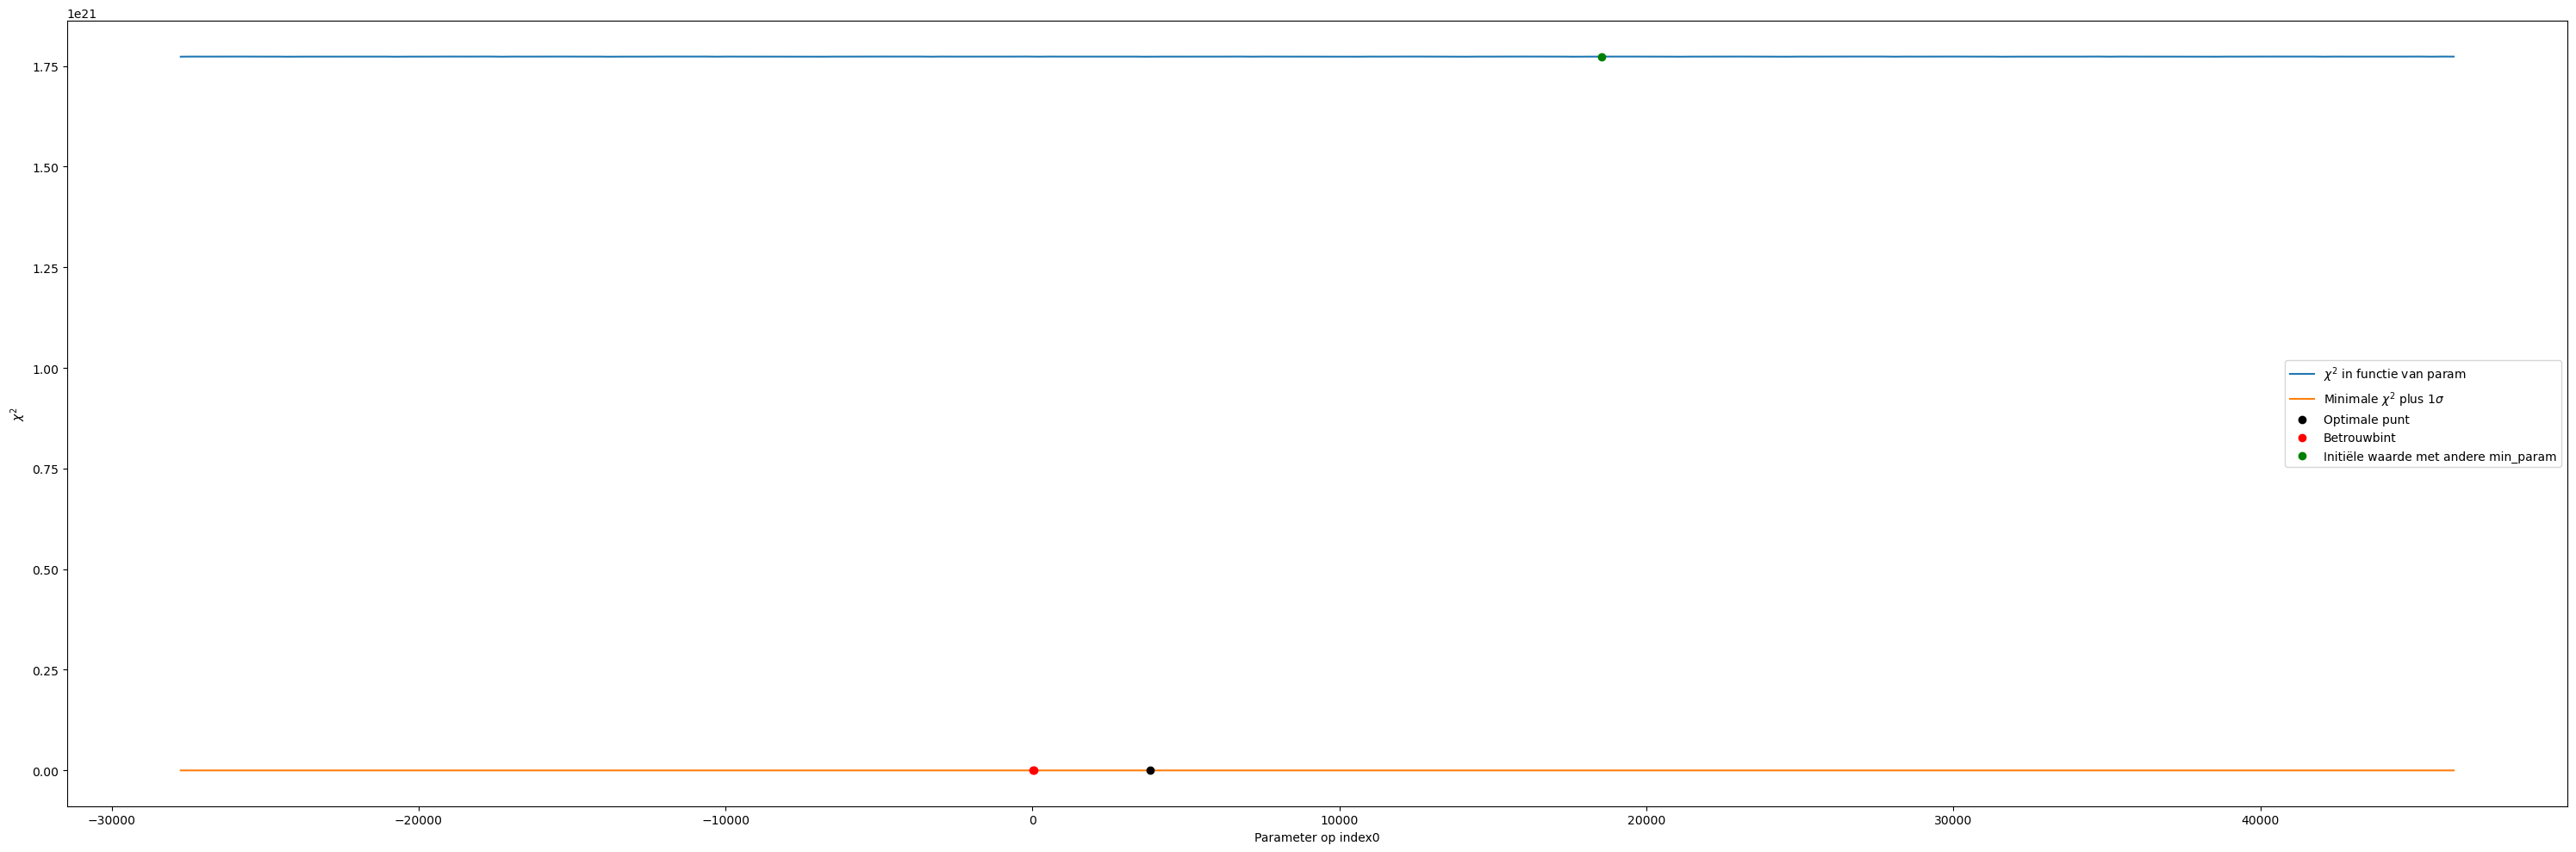

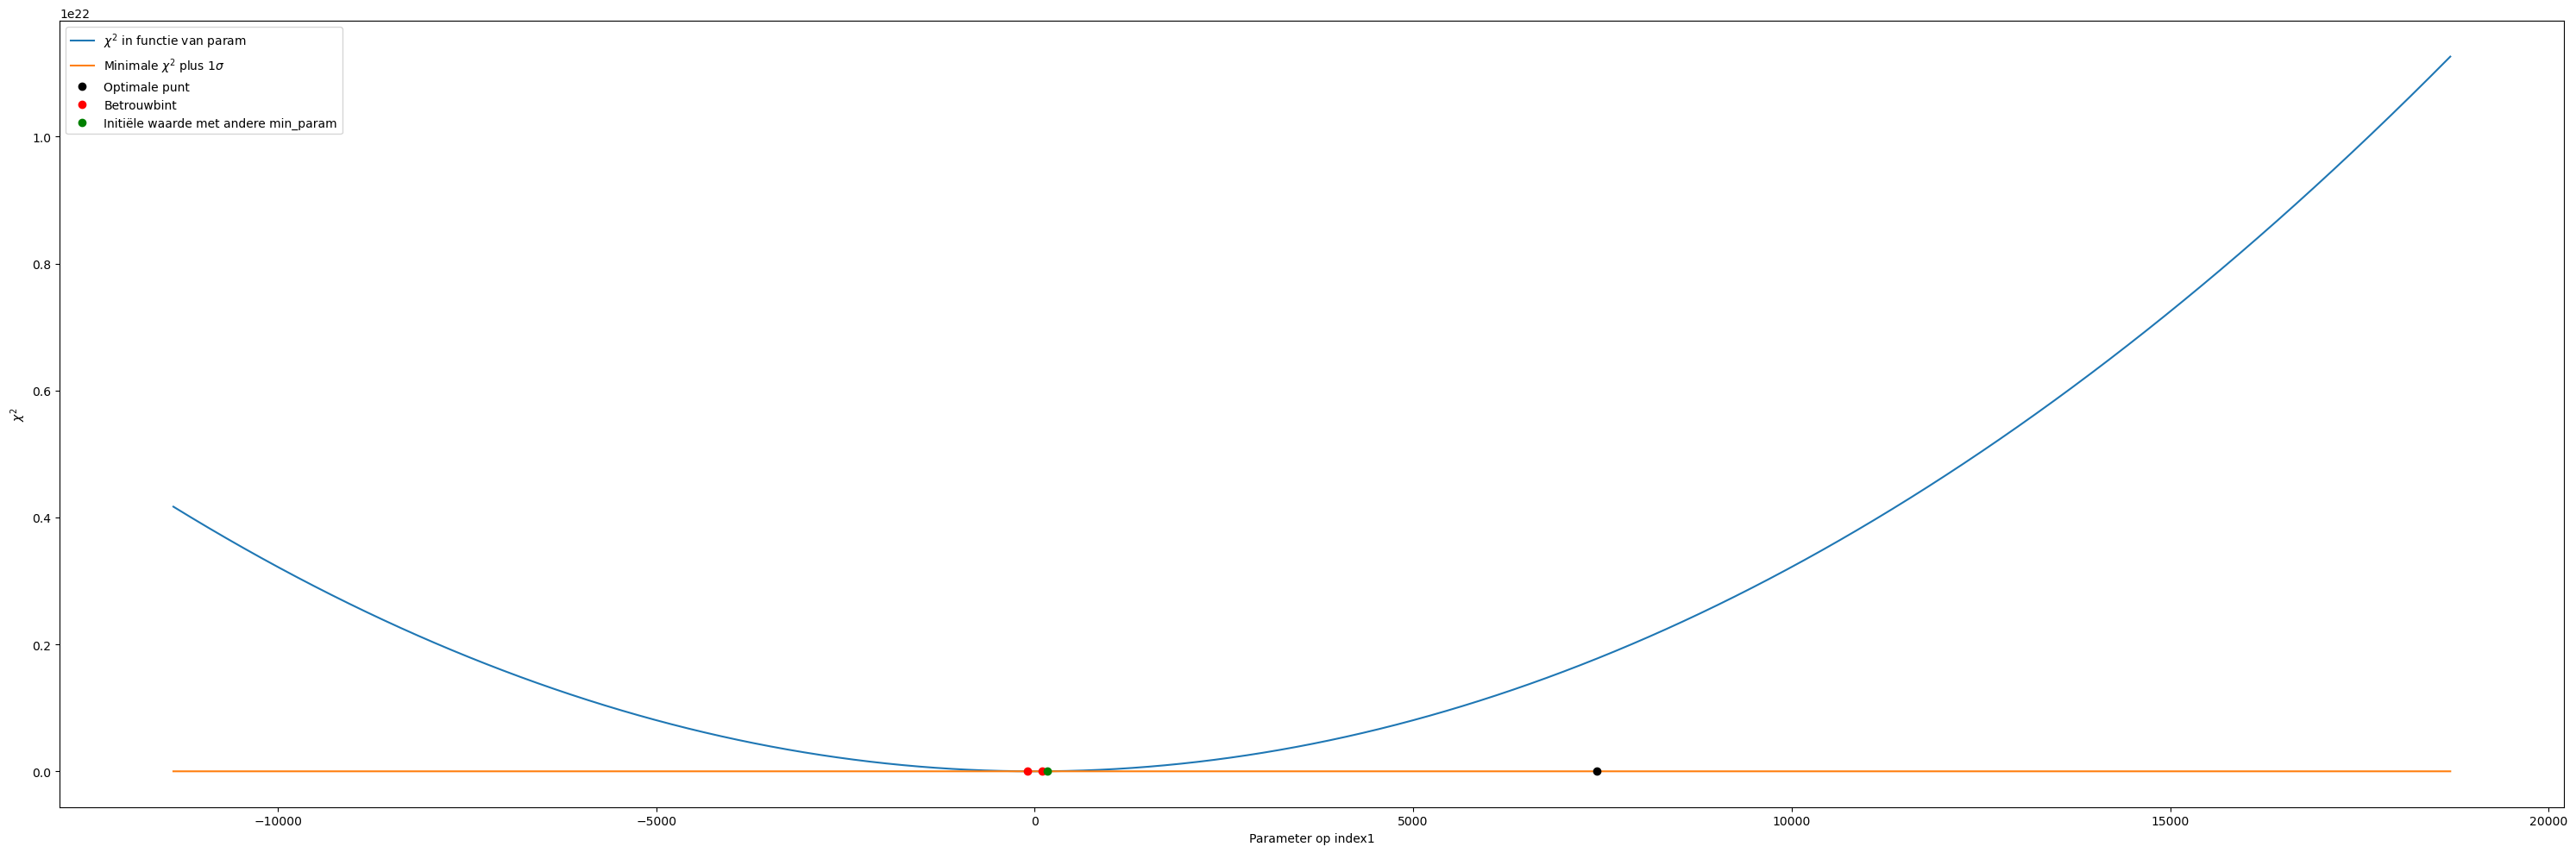

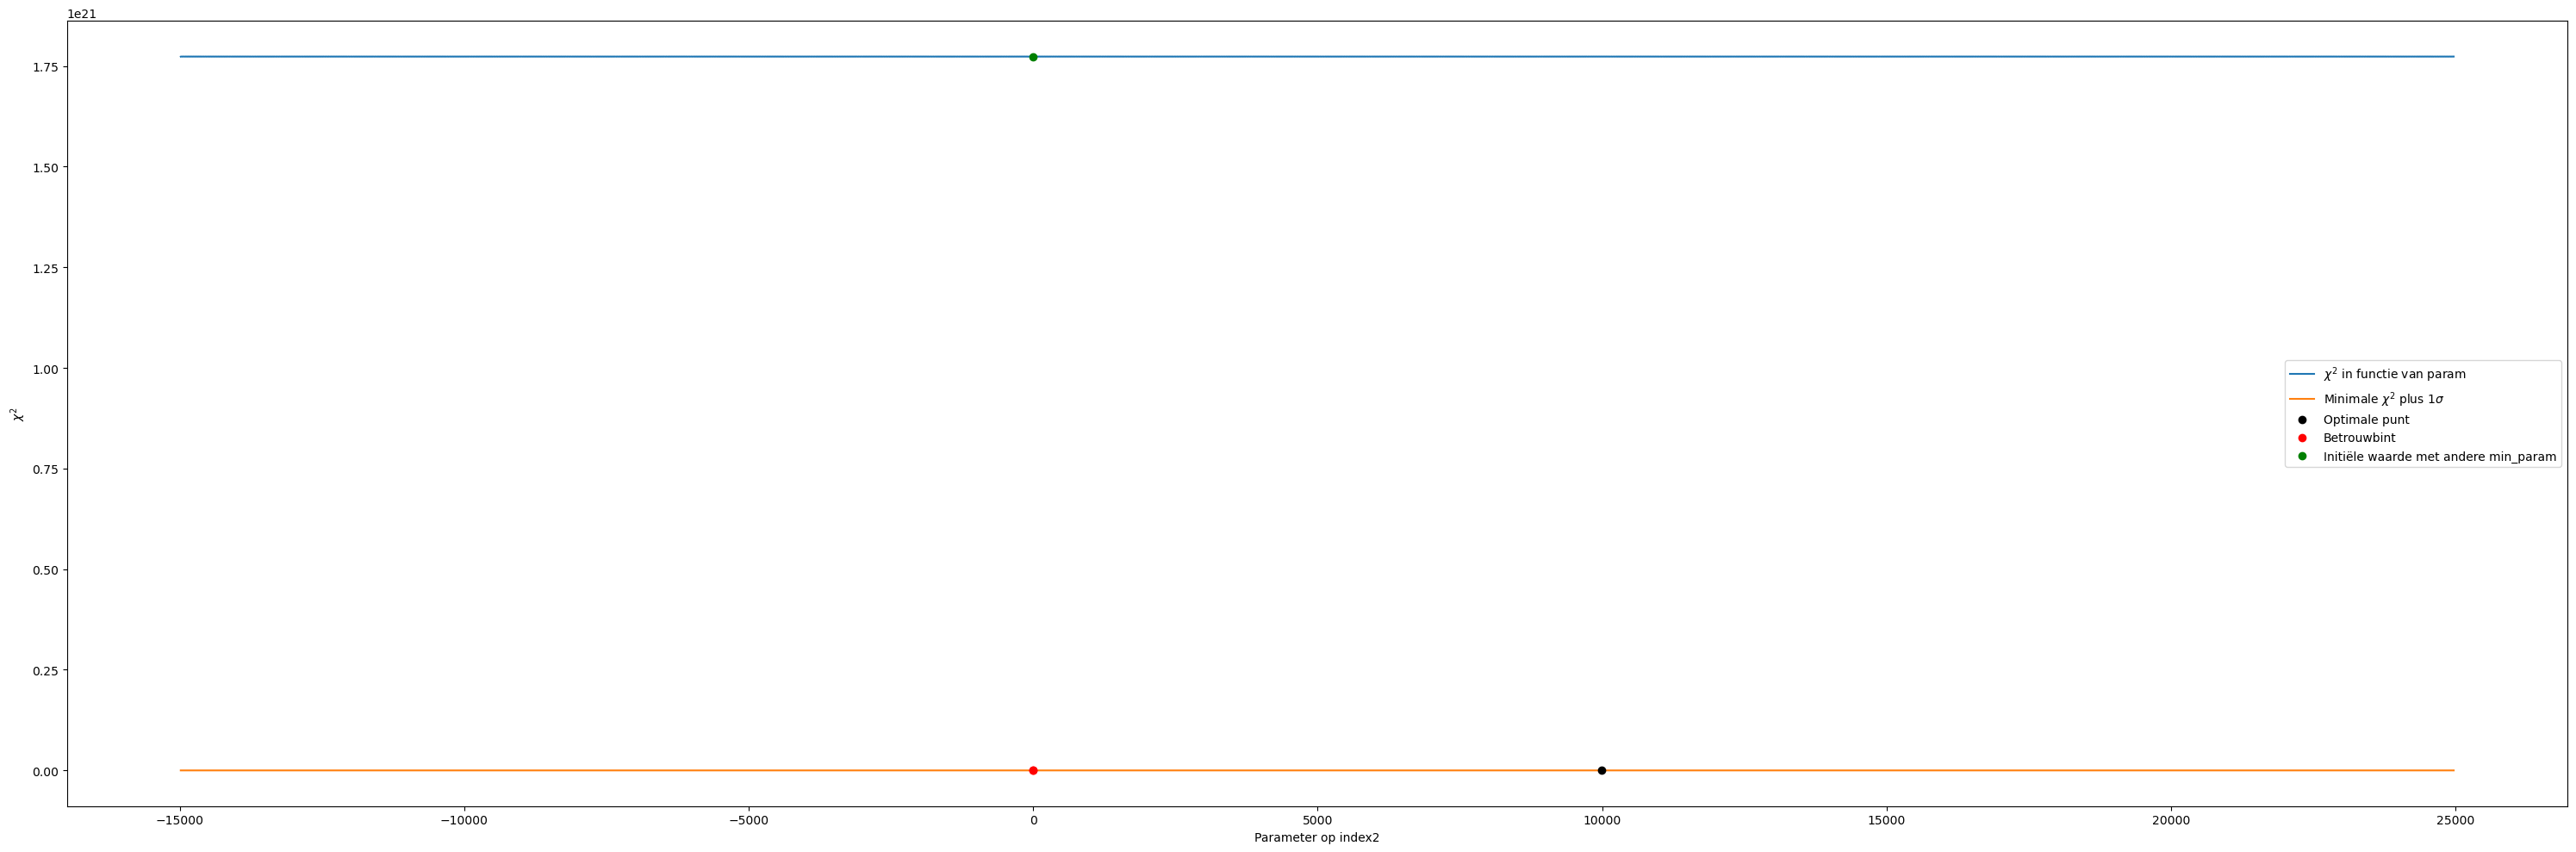

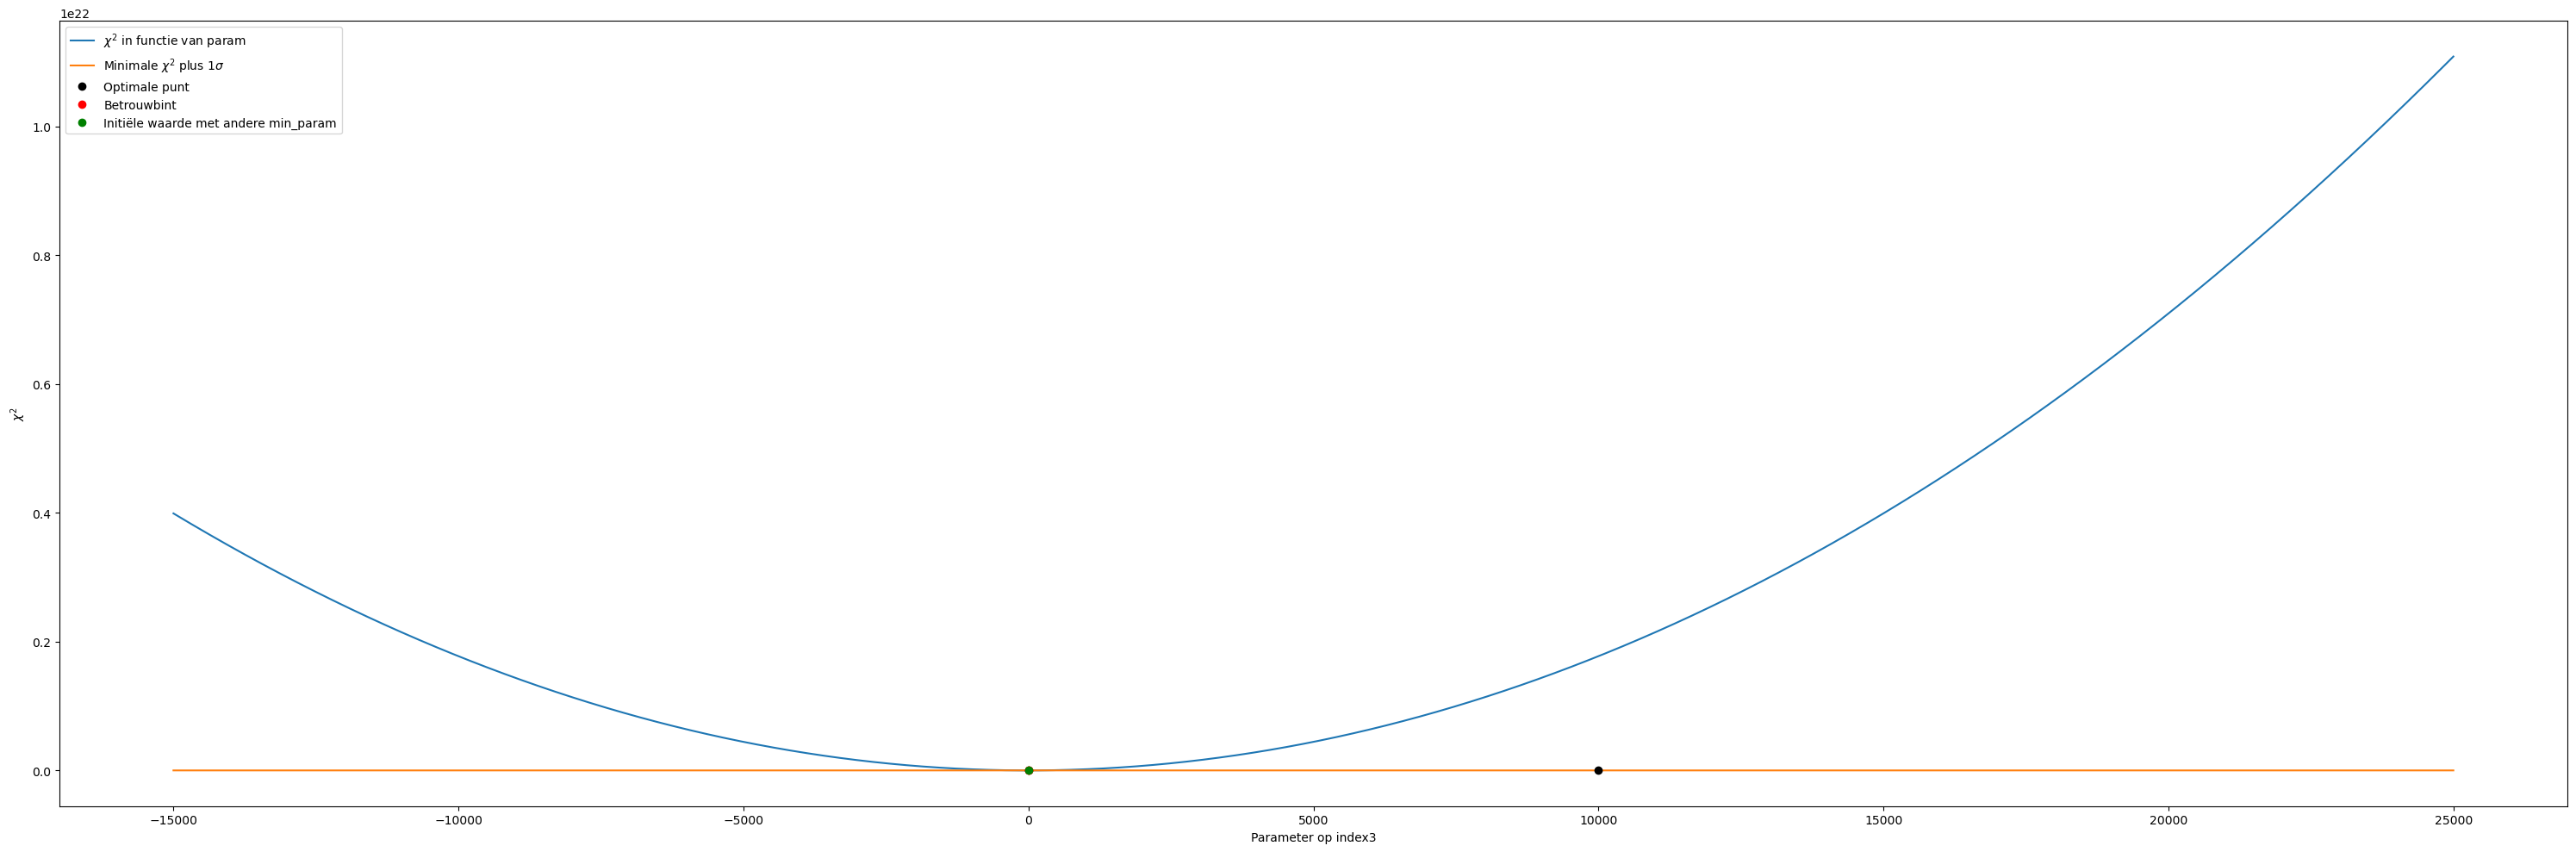

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 2.2717e+07


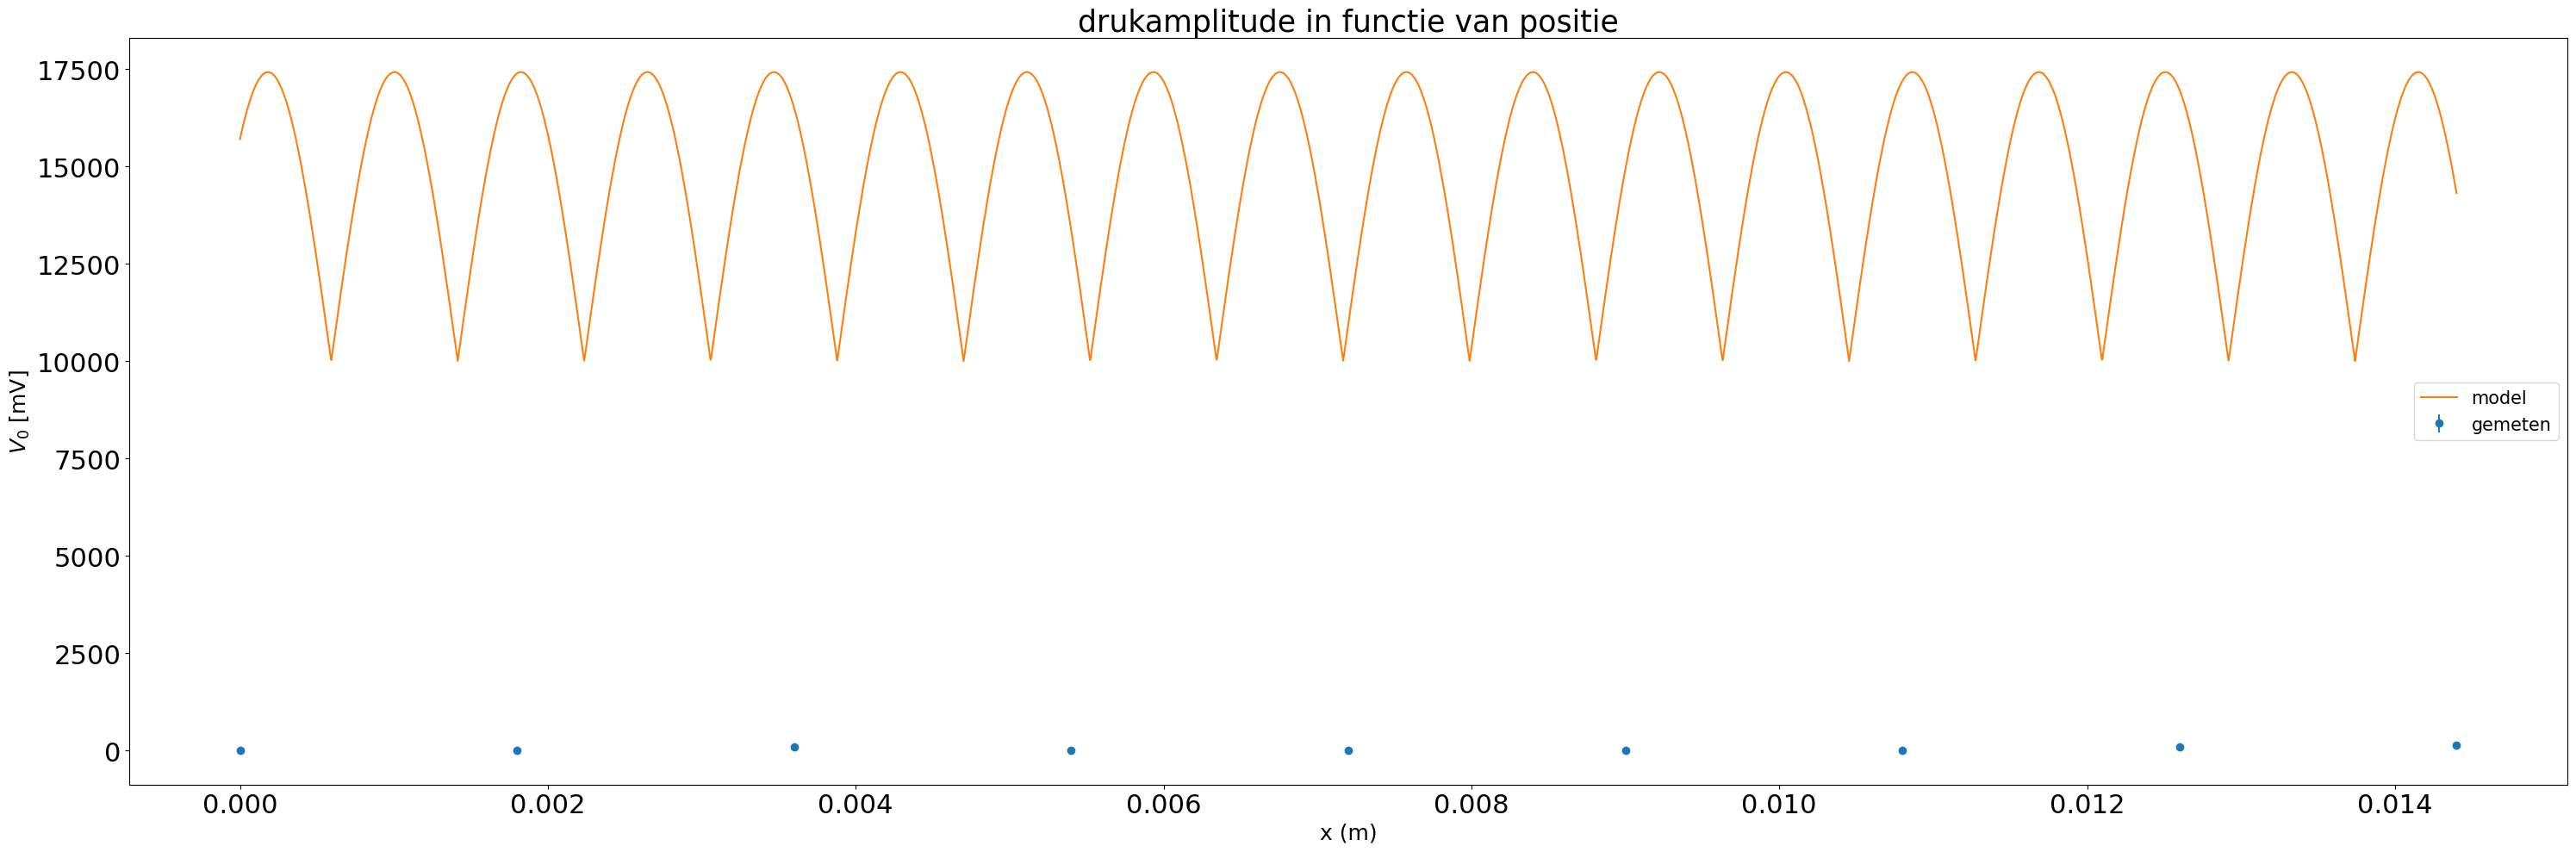

datapunt: v = [2549.32017219213, 2573.89110806836, 'Normaal']


IndexError: list index out of range

In [57]:
#de experimenten op 20cm

stappen = [1.8, 1.8] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 330, 430]
gokranges = [[(35, 50), (80, 120), (0,2.5), (0,20)], [(35.0, 50), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)], None]
fuggin = [False, True, False]
CPUfuggin = [True, True, False]
Kwaardes = []
omegawaardes = []
for indx in range(1,3):
    mypath = "metingen laweit/20cm, resfreq" + str(indx)
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
                                             detailed_logs=True, print_tijdfit = False, fit_x_vals=True, fuck_CPU = CPUfuggin[indx], saveto = mypath)
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')

In [ ]:
#de experimenten op 30cm

stappen = [1.9, 1.9] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 330, 430]
gokranges = [[(35, 50), (80, 120), (0,2.5), (0,20)], [(35.0, 50), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)], None]
fuggin = [False, True, False]
CPUfuggin = [True, True, False]
Kwaardes = []
omegawaardes = []
for indx in range(1,3):
    mypath = "metingen laweit/20cm, resfreq" + str(indx)
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
                                             detailed_logs=True, print_tijdfit = False, fit_x_vals=True, fuck_CPU = CPUfuggin[indx], saveto = mypath)
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')